<b>Data mining project - 2020/21</b><br>
<b>Authors</b>: [Alexandra Bradan](https://github.com/alexandrabradan), [Marianna Abbattista](https://github.com/Mariabba), [Eleonora Cocciu](https://github.com/eleonoracocciu) and [Dafina Leva](https://github.com/dafina-95)<br>
<b>Python version</b>: 3.x<br>
<b>Last update: 20/11/2020<b>

In [783]:
%matplotlib inline

# general libraries
import sys
import math
import collections
import missingno as msno
from pylab import MaxNLocator
from collections import defaultdict


# pandas libraries
import pandas as pd
from pandas import DataFrame
from pandas.testing import assert_frame_equal

# visualisation libraries
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot

# numpy libraries
import numpy as np
from numpy import std
from numpy import mean
from numpy import percentile

# scipy libraries
import scipy.stats as stats
from scipy.stats import kstest
from scipy.stats import normaltest

# sklearn libraries
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.experimental import enable_iterative_imputer  # explicitly require this experimental feature
from sklearn.impute import IterativeImputer

In [784]:
data_directory = "../../data/"
plot_directory = "../../plots/DataUnderstanding/"
TR_file = data_directory + "Train_HR_Employee_Attrition.csv"
TS_file = data_directory + "Test_HR_Employee_Attrition.csv"

<h1> Data understanding </h1>

In [785]:
df = pd.read_csv(TR_file, sep=",") 

In [786]:
df.head()  # first rows sneak peek

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,52.00,No,Travel_Rarely,593,Research & Development,9,4,Medical,2,Male,...,3,80.00,0,20,2.00,2,8.00,7,2,13
1,36.00,No,Travel_Rarely,1218,Research & Development,1,1,Life Sciences,2,Male,...,3,80.00,1,21,3.00,3,1.00,8,1,6
2,nan,No,Travel_Frequently,530,Sales,16,3,Life Sciences,3,NaN,...,3,nan,1,7,4.00,3,1.00,5,1,2
3,33.00,No,Travel_Rarely,953,Research & Development,5,4,Technical Degree,2,Male,...,2,nan,0,12,1.00,3,3.00,7,0,7
4,nan,No,Travel_Rarely,1380,Research & Development,9,2,Life Sciences,3,Female,...,3,80.00,0,2,nan,3,10.00,2,2,1


<h6> Rows that contain duplicate data identification </h6>

In [787]:
# calculate duplicated rows
dups = df.duplicated()
# report if there are any duplicates
print("Duplicate rows = ", dups.any(), sep="\t")

# list all duplicate rows
# print(df[dups])

# delete duplicate rows
# df.drop_duplicates(inplace=True)

Duplicate rows = 	False


<h6> Columns' data type and number of non-null elements identification </h6>

In [788]:
df.info() # DataFrame's summary

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1176 entries, 0 to 1175
Data columns (total 33 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       1000 non-null   float64
 1   Attrition                 1176 non-null   object 
 2   BusinessTravel            1069 non-null   object 
 3   DailyRate                 1176 non-null   int64  
 4   Department                1176 non-null   object 
 5   DistanceFromHome          1176 non-null   int64  
 6   Education                 1176 non-null   int64  
 7   EducationField            1176 non-null   object 
 8   EnvironmentSatisfaction   1176 non-null   int64  
 9   Gender                    1117 non-null   object 
 10  HourlyRate                1176 non-null   int64  
 11  JobInvolvement            1176 non-null   int64  
 12  JobLevel                  1176 non-null   int64  
 13  JobRole                   1176 non-null   object 
 14  JobSatis

Our dataframe contains 33 columns and 1175 rows. The following 8 columns have <b>missing values</b>:
- Age;
- BusinessTravel;
- Gender;
- MonthlyIncome;
- Over18;
- PerformanceRating;
- StandardHours;
- TrainingTimesLastYear. 

The missing values will be replaced in section <b>Missing data imputation</b>. 

Since all 9 objects columns are <b>nominal/ordinal attributes</b>, they must be converted to integer values:
- Attrition;
- BusinessTravel;
- Department;
- EducationField;
- Gender;
- JobRole;
- MaritalStatus;
- Over18;
- OverTime.

The categorical/ordinal attributes will be encoded in section <b>Type conversion (Part 1)</b>.

All 6 float64 columns have <b>misinterpreted data types</b> (ideally, it's better to express thems as int64):
- Age;
- MonthlyIncome;
- PerformanceRating;
- StandardHours;
- TrainingTimesLastYear
- YearsAtCompany.

The misinterpreted data types will be converted in section <b>Type conversion (Part 2)</b>.

We will see that some columns are non meaningful to our analysis in section <b>Dimensionality Reduction (Part 1)</b> and others are correlated among them, as described in section <b>Dimensionality Reduction (Part 2)</b>.
    
Finally, we will perform discretisation on some of our numerical features in section <b>Data discretisation </b> and we will extract some additional and useful features in section <b>Additional feature extraction</b>.

<h6>Graphical visualize null values</h6>

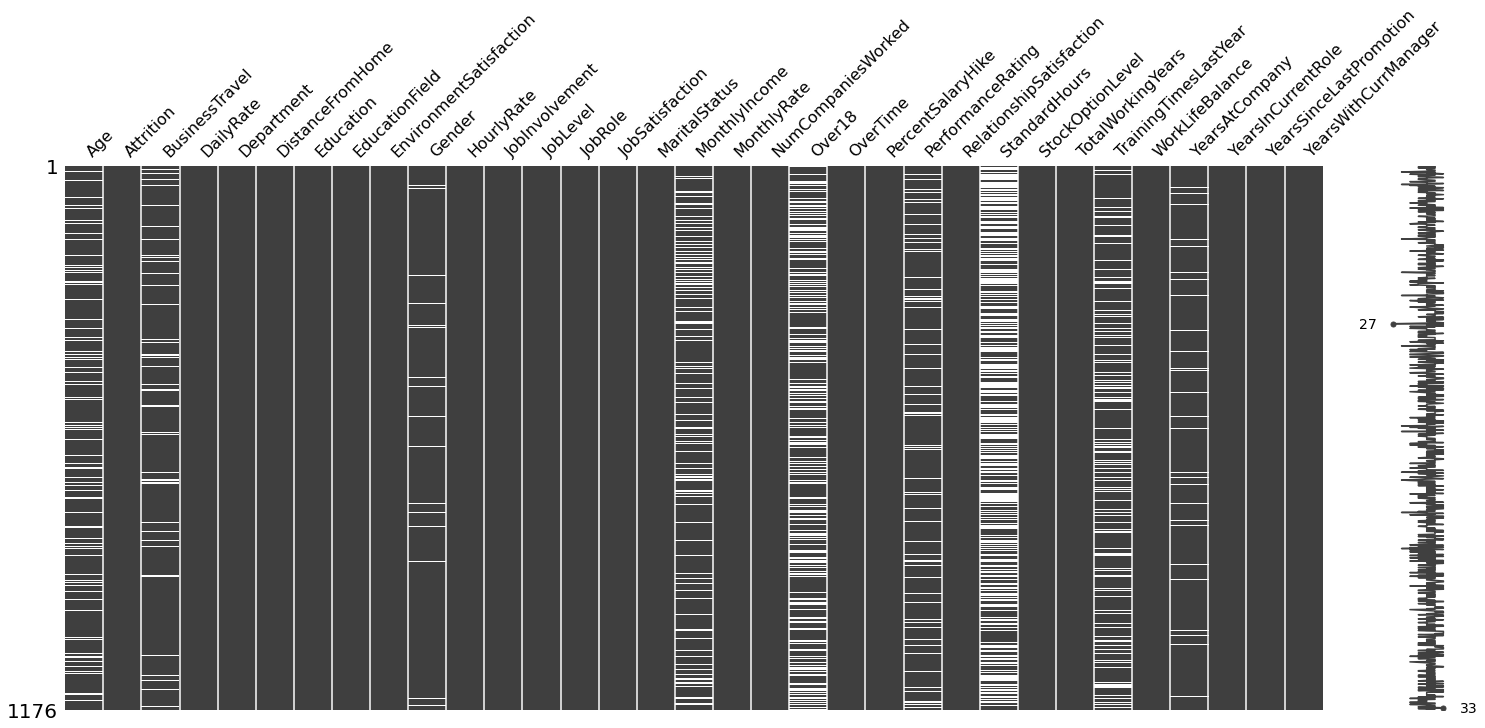

In [789]:
msno.matrix(df)

The <b>missingno library</b> confirms that our dataset has the above 9 missing features.

<h6> Zero values detection </h6>
Numerical attributes might also present missing values (i.e. represented by zero values)

In [790]:
data_types = df.dtypes
for column_name, column_type in data_types.items():
    if column_type == np.int or column_type == np.float:
        zero_values = (df[column_name] == 0).sum()
        if zero_values > 0:
            print(column_name, zero_values, sep="\t")

NumCompaniesWorked	153
StockOptionLevel	514
TotalWorkingYears	10
TrainingTimesLastYear	32
YearsAtCompany	32
YearsInCurrentRole	204
YearsSinceLastPromotion	472
YearsWithCurrManager	214


We think that all zero valued 8 columns found above present meaningful data encoded in this numerical null values, therefore, these values are not involved in the process of replacing missing values:
- NumCompaniesWorked = 0: first company in which an employee is working;
- StockOptionLevel	= 0: no StockOptionLevel granted to employee;
- TotalWorkingYears	= 0: employee is present less than a year in the job world;
- TrainingTimesLastYear	= 0: no training time last year;
- YearsAtCompany	= 0: employee works less than a year at company;
- YearsInCurrentRole	= 0: employee works less than a year in current role;
- YearsSinceLastPromotion	= 0: employee had been promoted less than a year ago;
- YearsWithCurrManager	= 0: employee is less than a year under current manager.

We notice that 32 employees have "YearsAtCompany" and "TrainingTimesLastYear" values set to 0, so we can hypothesize that they are new employees, hired less than a year ago and so they could not have been trained in a year previous to their admission.	To validate our hypothesis we join the rows where both columns have null values:

In [791]:
df[(df["YearsAtCompany"] == 0) & (df["TrainingTimesLastYear"] == 0)]

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
396,18.00,No,Non-Travel,895,Research & Development,15,2,Life Sciences,1,Male,...,4,nan,1,4,0.00,2,0.00,2,2,2


Actually, we find out that out of the 32 new employees only 1 hadn't had previous training, so the other 31 new employees must had undergone their training with their previous companies, leaving out our hypothesis that "new employee equals no training time last year", as confirmed bellow:

In [792]:
previous_training_flag = True
for index, train_t in df[(df["YearsAtCompany"] == 0)]["TrainingTimesLastYear"].items():
    if train_t == 0:  # new employee hadn't been trained last year
        previous_companies_flag = False
if previous_training_flag:
    print("All new employees were trained at previous company last year")
else:
     print("Some new employees weren't trained at previous company last year")

All new employees were trained at previous company last year


<h2> Dimensionality Reduction (Part 1) </h2>
Dimensionality reduction refers to techniques that reduce the number of input variables in a dataset.
We can consider the columns of data representing dimensions on an n-dimensional feature space and the rows of data as points in that space. 
Having a large number of dimensions in the feature space can mean that the volume of that space is very large, and in turn, the points that we have in that space (rows of data) often represent a small and non-representative sample. This can dramatically impact the performance of machine learning algorithms fit on data (this is generally reffered as the <b>curse of dimensionality</b>). 
Therefore, it is often desirable to reduce the number of input features, to prevent the model to overfit.

Dimensionality reduction techniques remove irrilevant features, such as methods that remove redundant variables using correlation (see <b>Dimensionality Reduction (Part 2)</b> section) or features that have few values or low variance (i.e. data cleaning), covered in this section.

<h6> Columns unique values lookup </h6>

In [793]:
column_names = list(df.columns)
for column_name in column_names: 
    unique_values = df[column_name].unique()
    if len(unique_values) >= 10:
        print(column_name, "more than 10 %s values" % df.dtypes[column_name], sep="\t")
    else:
         print(column_name, unique_values, sep="\t")

Age	more than 10 float64 values
Attrition	['No' 'Yes']
BusinessTravel	['Travel_Rarely' 'Travel_Frequently' nan 'Non-Travel']
DailyRate	more than 10 int64 values
Department	['Research & Development' 'Sales' 'Human Resources']
DistanceFromHome	more than 10 int64 values
Education	[4 1 3 2 5]
EducationField	['Medical' 'Life Sciences' 'Technical Degree' 'Other' 'Human Resources'
 'Marketing']
EnvironmentSatisfaction	[2 3 4 1]
Gender	['Male' nan 'Female']
HourlyRate	more than 10 int64 values
JobInvolvement	[3 4 1 2]
JobLevel	[3 5 2 1 4]
JobRole	['Research Director' 'Manager' 'Sales Executive' 'Research Scientist'
 'Laboratory Technician' 'Sales Representative' 'Manufacturing Director'
 'Healthcare Representative' 'Human Resources']
JobSatisfaction	[3 4 2 1]
MaritalStatus	['Single' 'Divorced' 'Married']
MonthlyIncome	more than 10 float64 values
MonthlyRate	more than 10 int64 values
NumCompaniesWorked	more than 10 int64 values
Over18	[nan 'Y']
OverTime	['No' 'Yes']
PercentSalaryHike	more than 

Our datasest is a mixture of categorical/numerical attributes, sorted as follows:

<b>numerical discrete data (15):</b>
- Age;
- DailyRate;
- DistanceFromHome;
- HourlyRate;
- MonthlyIncome;
- MonthlyRate;
- NumCompaniesWorked;
- PercentSalaryHike;
- StandardHours;
- TotalWorkingYears;
- YearsAtCompany;
- YearsInCurrentRole;
- YearsSinceLastPromotion;
- YearsWithCurrManager. 

<b>categorical nominal data (9):</b>
- Attrition;
- BusinessTravel;
- Department;
- EducationField;
- Gender;
- JobRole;
- MaritalStatus
- Over18;
- OverTime.

<b>categorical ordinal data (9):</b>
- Education;
- EnvironmentSatisfaction;
- JobInvolvement;
- JobLevel;
- JobSatisfaction;
- PerformanceRating;
- RelationshipSatisfaction;
- StockOptionLevel;
- TrainingTimesLastYear;
- WorkLifeBalance.

Since column <b>TrainingTimesLastYear</b> ranges between \[0-6\], we evaluate it as being of <b>categorical ordinal type</b>.

<h6> Zero-variance predictors (columns which contains a single value) identification => no variation displayed by the predictor, so we will remove them </h6>

In [794]:
# summarize the number of unique values in each column
counts = df.nunique()
# remove (columns which contains a single value (number of unique values = 1)
zero_variance_predictors = [df.columns.values.tolist()[int(i)] for i, c in enumerate(counts) if c == 1]  
for column_name in zero_variance_predictors:
    del df[column_name]  # remove zero_variance_predictors
    print("zero_variance_predictors removed ", column_name, sep="\t")
df.shape  # check DataFrame dimensions

zero_variance_predictors removed 	Over18
zero_variance_predictors removed 	StandardHours


(1176, 31)

Now our Dataframe stores 1176 rows and 31 columns. One-valued columns dropping is explained as follows: 
- "Over18" column is redudant, since it can be deducted from "Age" column;
- "StandardHours" column is meaningless, since the only values are "80" and "NaN"

Our intuition suggests that:
- column "OverTime" is semantically correlated with "StandardHours" column; so, by dropping it, we may have to drop "OverTime" column, too. More investigation is needed; @TODO 
- column "PerformanceRating" has only 3, 4 and NaN values, which is a useless rate to validate employees' performance,since by measuring the performance with following scale:
$$Low=1, Good=2, Excellent=3, Outstanding=4$$
employees' performance doesn't help to discrimenate an exemplary employee and one not. For this reason we will remove thi feature.

In [795]:
del df["PerformanceRating"]  # remove not relevant predictor
print("meaningless predictor removed ", "PerformanceRating", sep="\t")

meaningless predictor removed 	PerformanceRating


In [796]:
df.shape  # check DataFrame dimensions

(1176, 30)

Now our Dataframe stores 1176 rows and 30 columns.

<h2> Variables distribution </h2>

<h6> Drawing countplots for categorical data </h6>

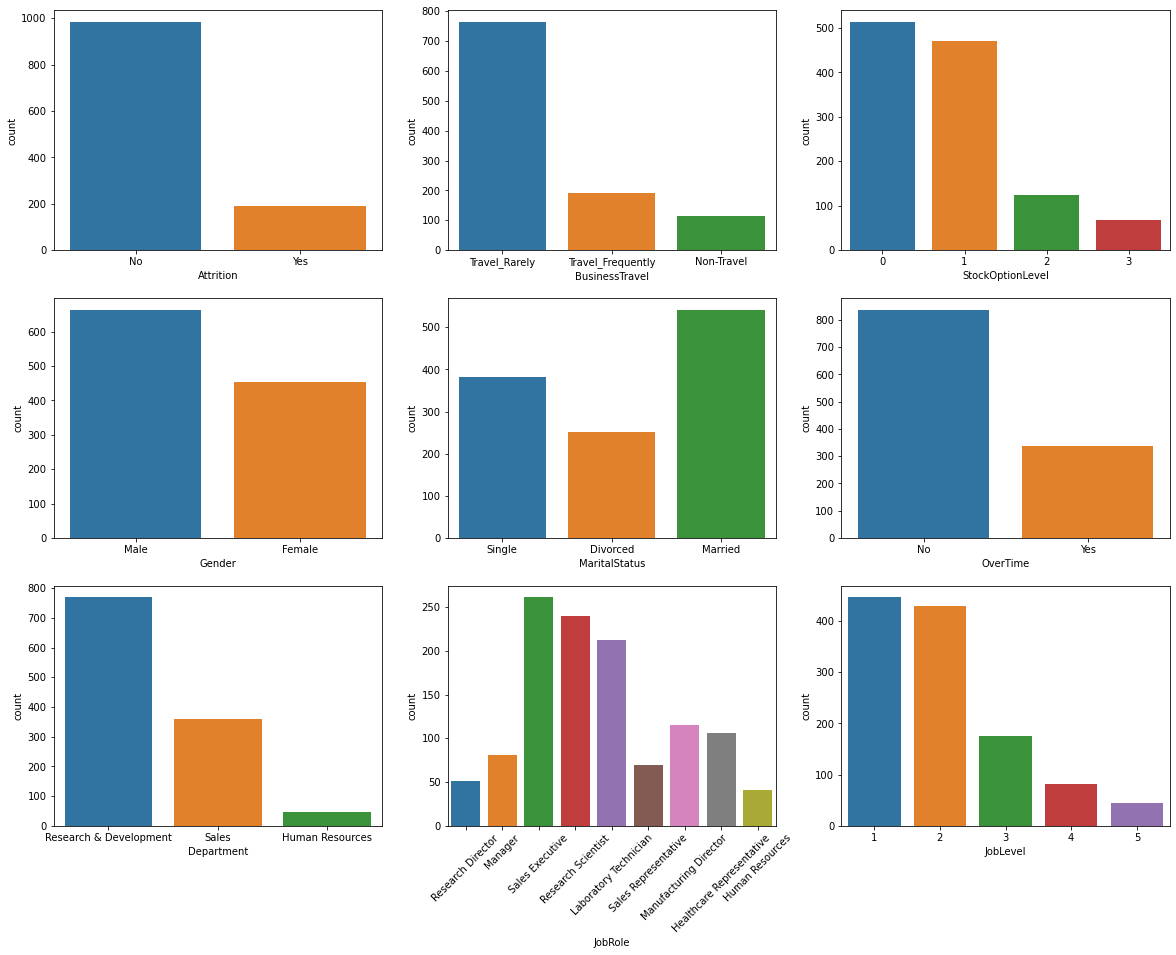

In [797]:
fig = plt.subplots(figsize=(20, 15))
fig_dims = (3, 3)

ax = plt.subplot2grid(fig_dims, (0, 0))
sns.countplot(x="Attrition", data=df)
ax = plt.subplot2grid(fig_dims, (0, 1))
sns.countplot(x="BusinessTravel", data=df)
ax = plt.subplot2grid(fig_dims, (0, 2))
sns.countplot(x="StockOptionLevel", data=df)

ax = plt.subplot2grid(fig_dims, (1, 0))
sns.countplot(x="Gender", data=df)
ax = plt.subplot2grid(fig_dims, (1, 1))
sns.countplot(x="MaritalStatus", data=df)
ax = plt.subplot2grid(fig_dims, (1, 2))
sns.countplot(x="OverTime", data=df)

ax = plt.subplot2grid(fig_dims, (2, 0))
sns.countplot(x="Department", data=df)
ax = plt.subplot2grid(fig_dims, (2, 1))
sns.countplot(x="JobRole", data=df)
plt.xticks(rotation=45)
ax = plt.subplot2grid(fig_dims, (2, 2))
sns.countplot(x="JobLevel", data=df)

plt.show()

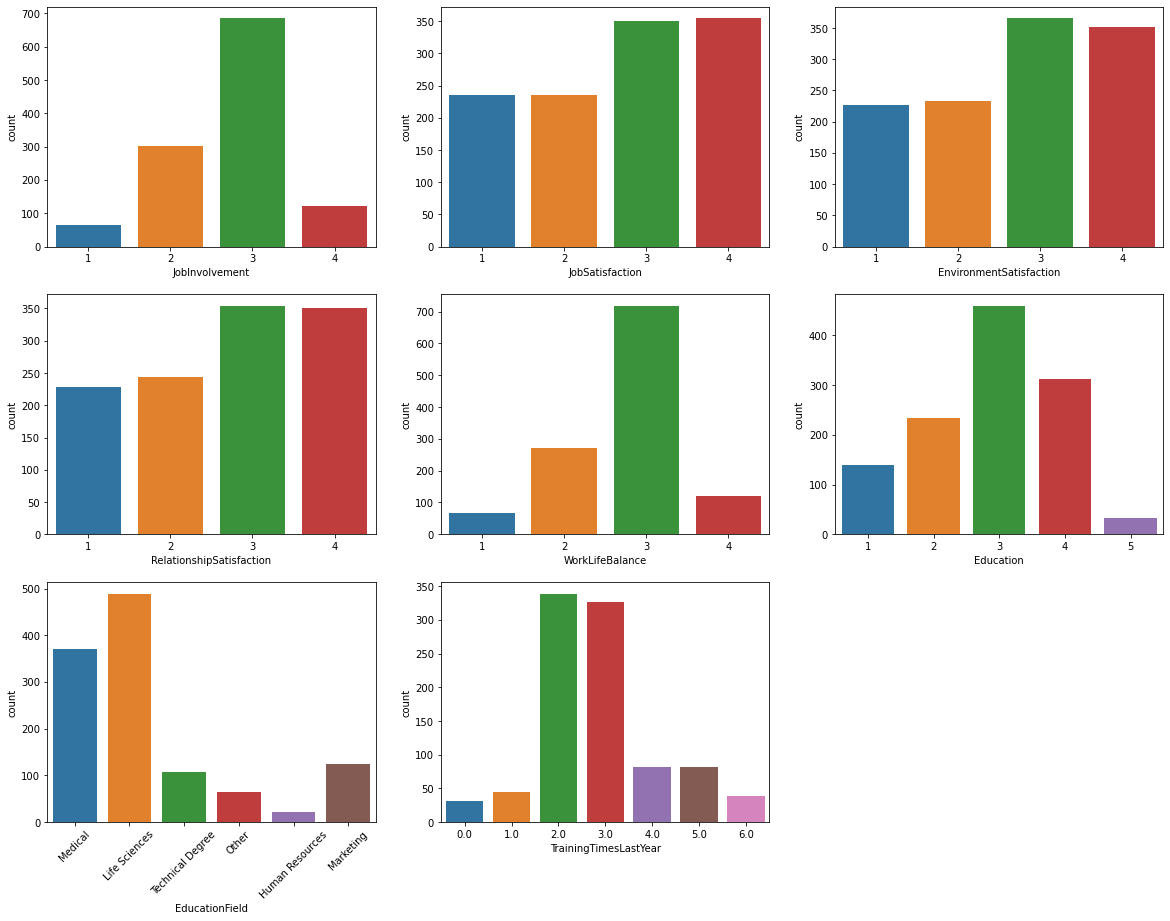

In [798]:
fig =plt.subplots(figsize=(20, 15))
fig_dims = (3, 3)

ax = plt.subplot2grid(fig_dims, (0, 0))
sns.countplot(x="JobInvolvement", data=df)
ax = plt.subplot2grid(fig_dims, (0, 1))
sns.countplot(x="JobSatisfaction", data=df)
ax = plt.subplot2grid(fig_dims, (0, 2))
sns.countplot(x="EnvironmentSatisfaction", data=df)

ax = plt.subplot2grid(fig_dims, (1, 0))
sns.countplot(x="RelationshipSatisfaction", data=df)
ax = plt.subplot2grid(fig_dims, (1, 1))
sns.countplot(x="WorkLifeBalance", data=df)
ax = plt.subplot2grid(fig_dims, (1, 2))
sns.countplot(x="Education", data=df)


ax = plt.subplot2grid(fig_dims, (2, 0))
sns.countplot(x="EducationField", data=df)
plt.xticks(rotation=45)
ax = plt.subplot2grid(fig_dims, (2, 1))
sns.countplot(x="TrainingTimesLastYear", data=df)


plt.show()

In [799]:
df["YearsWithCurrManager"].mean()

4.107993197278912

<h6> Drawing histograms for numerical data</h6>

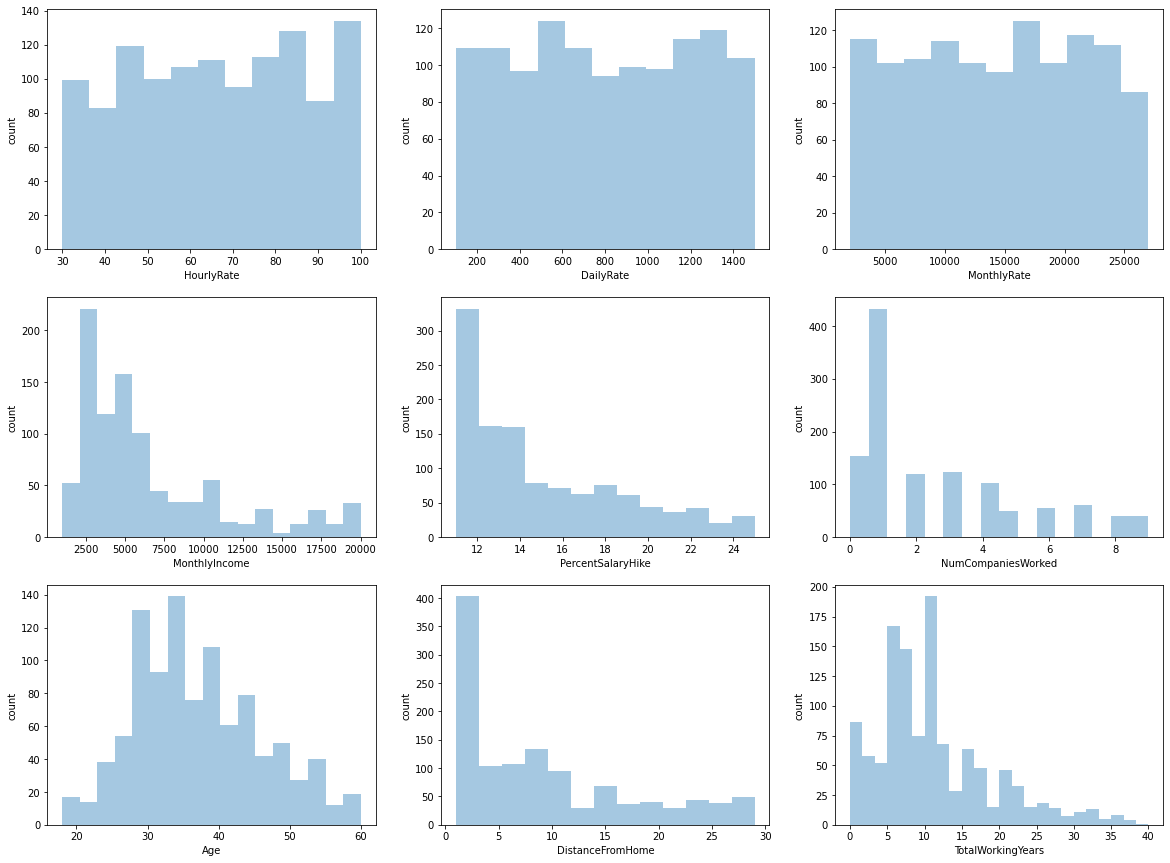

In [800]:
fig =plt.subplots(figsize=(20, 15))
fig_dims = (3, 3)

ax = plt.subplot2grid(fig_dims, (0, 0))
sns.distplot(df["HourlyRate"].dropna(), kde=False)
plt.ylabel("count")
ax = plt.subplot2grid(fig_dims, (0, 1))
sns.distplot(df["DailyRate"].dropna(), kde=False)
plt.ylabel("count")
ax = plt.subplot2grid(fig_dims, (0, 2))
sns.distplot(df["MonthlyRate"].dropna(), kde=False)
plt.ylabel("count")

ax = plt.subplot2grid(fig_dims, (1, 0))
sns.distplot(df["MonthlyIncome"].dropna(), kde=False)
plt.ylabel("count")
ax = plt.subplot2grid(fig_dims, (1, 1))
sns.distplot(df["PercentSalaryHike"].dropna(), kde=False)
plt.ylabel("count")
ax = plt.subplot2grid(fig_dims, (1, 2))
sns.distplot(df["NumCompaniesWorked"].dropna(), kde=False)
plt.ylabel("count")


ax = plt.subplot2grid(fig_dims, (2, 0))
sns.distplot(df["Age"].dropna(), kde=False)
plt.ylabel("count")
ax = plt.subplot2grid(fig_dims, (2, 1))
sns.distplot(df["DistanceFromHome"].dropna(), kde=False)
plt.ylabel("count")
ax = plt.subplot2grid(fig_dims, (2, 2))
sns.distplot(df["TotalWorkingYears"].dropna(), kde=False)
plt.ylabel("count")
plt.show()

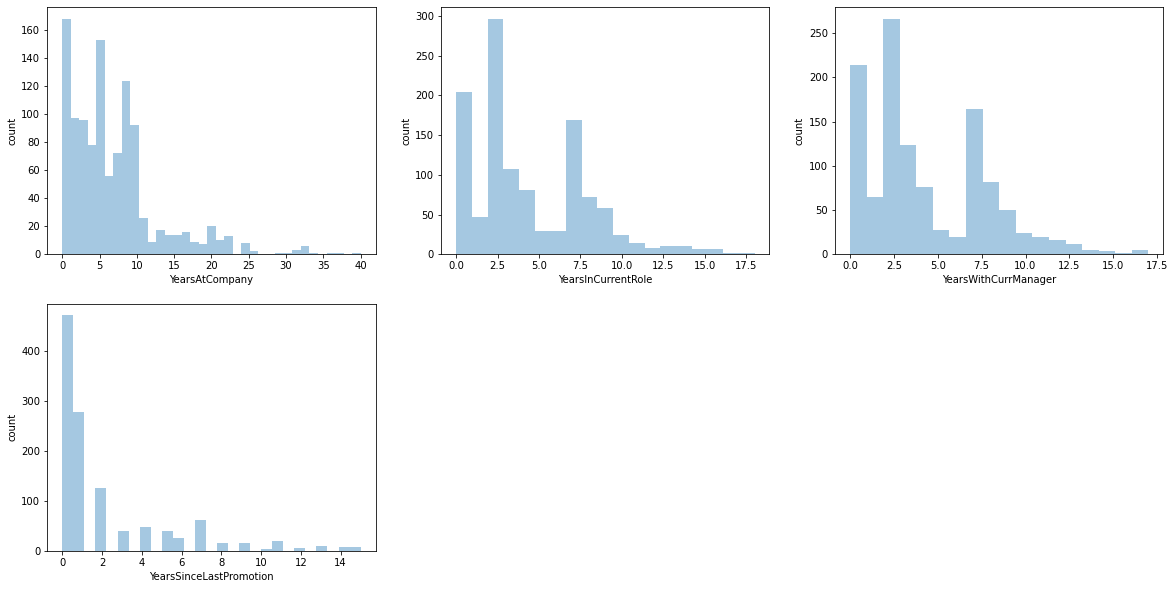

In [801]:
fig =plt.subplots(figsize=(20, 10))
fig_dims = (2, 3)

ax = plt.subplot2grid(fig_dims, (0, 0))
sns.distplot(df["YearsAtCompany"].dropna(), kde=False)
plt.ylabel("count")
ax = plt.subplot2grid(fig_dims, (0, 1))
sns.distplot(df["YearsInCurrentRole"].dropna(), kde=False)
plt.ylabel("count")
ax = plt.subplot2grid(fig_dims, (0, 2))
sns.distplot(df["YearsWithCurrManager"].dropna(), kde=False)
plt.ylabel("count")

ax = plt.subplot2grid(fig_dims, (1, 0))
sns.distplot(df["YearsSinceLastPromotion"].dropna(), kde=False)
plt.ylabel("count")

plt.show()

More than half of the employees present in our dataset are married men, have on avergae 37 years, are about 9 units far apart from the workplace, in general travel rarerly, have a Life Science Bachelor Degree explained probably due to a greater availability of workpositions in the Reserch&Development department, where they work mainly as level 1-2 Sale Executives, Reasearch Scientists and Laboratory Technicians. They are holding their current job roles on average for 4 years, but every 2 years they are liabile to promotions. Their work stability is also safeguarded by managers' shift every 4 years. They have a background of 2 to 3 previous companies and on average  a total of 11 working years.

Almost all employees aren't leaving the company (no Attrition) and in fact they are compelled to stay by granting them on average 1 company's stock and on average 15% of salary hike. Their years at company are on average 7, last year they have undergone a mean of 3 training times, they mainly don't work overtime and as a conseguence they gave an overall high or very high score to WorkLifeBalance, JobInvolvement, JobSatistaction, EnvironmentSatisfaction and RelationshipSatisfaction.

These high satisfaction and involvement scores are explained also by their hourly, daily and monthly rates:

In [802]:
def get_mean_ratio(column_name1, column_name2):
    tmp_df = df[[column_name1, column_name2]].dropna()
    tmp_list = []

    for index, row in tmp_df.iterrows():
        ratio = row[column_name1] / row[column_name2]
        tmp_list.append(ratio)

    return np.mean(tmp_list)

In [803]:
def get_mean_difference(column_name1, column_name2):
    tmp_df = df[[column_name1, column_name2]].dropna()
    tmp_list = []

    for index, row in tmp_df.iterrows():
        ratio = row[column_name1] - row[column_name2]
        tmp_list.append(ratio)

    return np.mean(tmp_list)

In [804]:
# get hourly rate
df["HourlyRate"].mean()  

66.29931972789116

In [805]:
# get daily working hours
print(get_mean_ratio("DailyRate", "HourlyRate"))

13.52171951835856


In [806]:
# get daily rate
df["DailyRate"].mean()  

803.6505102040817

In [807]:
# get monthly working days
print(get_mean_ratio("MonthlyRate", "DailyRate"))

27.972016084025142


In [808]:
# get monthly rate
df["MonthlyIncome"].mean()

6565.946002076843

In [809]:
# get monthly salary
df["MonthlyRate"].mean()

14395.836734693878

In [810]:
# get ratio between "MonthlyRate" and "MonthlyIncome" 
print(get_mean_ratio("MonthlyRate", "MonthlyIncome"))

3.314494672132683


In [811]:
# get difference between "MonthlyRate" and "MonthlyIncome" 
get_mean_difference("MonthlyRate", "MonthlyIncome")

7733.578400830737

In [812]:
# compute hourly and daily salary
hourly_salaries = []
daily_salaries = []
tmp_df = df[["MonthlyRate", "MonthlyIncome", "DailyRate", "HourlyRate"]].dropna()

for index, row in tmp_df.iterrows():
    diff = row["MonthlyRate"] / row["MonthlyIncome"]
    hourly_salaries.append(row["HourlyRate"] / diff)
    daily_salaries.append(row["DailyRate"] / diff)

print(np.mean(hourly_salaries))
print(np.mean(daily_salaries))

45.22092914585226
560.8214511082923


We found out that company's employees work on average <b>13.5 hours a day</b>, by dividing "DailyRate" with "HourlyRate".
We believe that they are working their standard contract hours and afterwards they still must be contactable.
We discovered by dividing "MonthlyRate" with "DailyRate" that they work on average <b>28 days a month</b>, likely having Sunday free and other weekdays where they must be contactable. By dividing the <b>"MonthlyRate"</b> (interpreted as company's employee cost (salary, social insurance, administration, logistics, over head, etc)) with the <b>"MonthlyIncome"</b> (interpreted as employe's earned monthly) we learnt that the first is <b>triple</b> the second, so we can hypothesize that also the "HourlyRate" and the "DailyRate" are triple in respect to the the "HourlyIncome" and "DailyIncome" (these last two information are missing). By taking into account this hypothesis, company's employees gaint on average 45.22\\$ per hour, 560.82\\$ per day and 6565.95\\$ per month.

<h6>Drawing curve fitting for numerical data </h6>

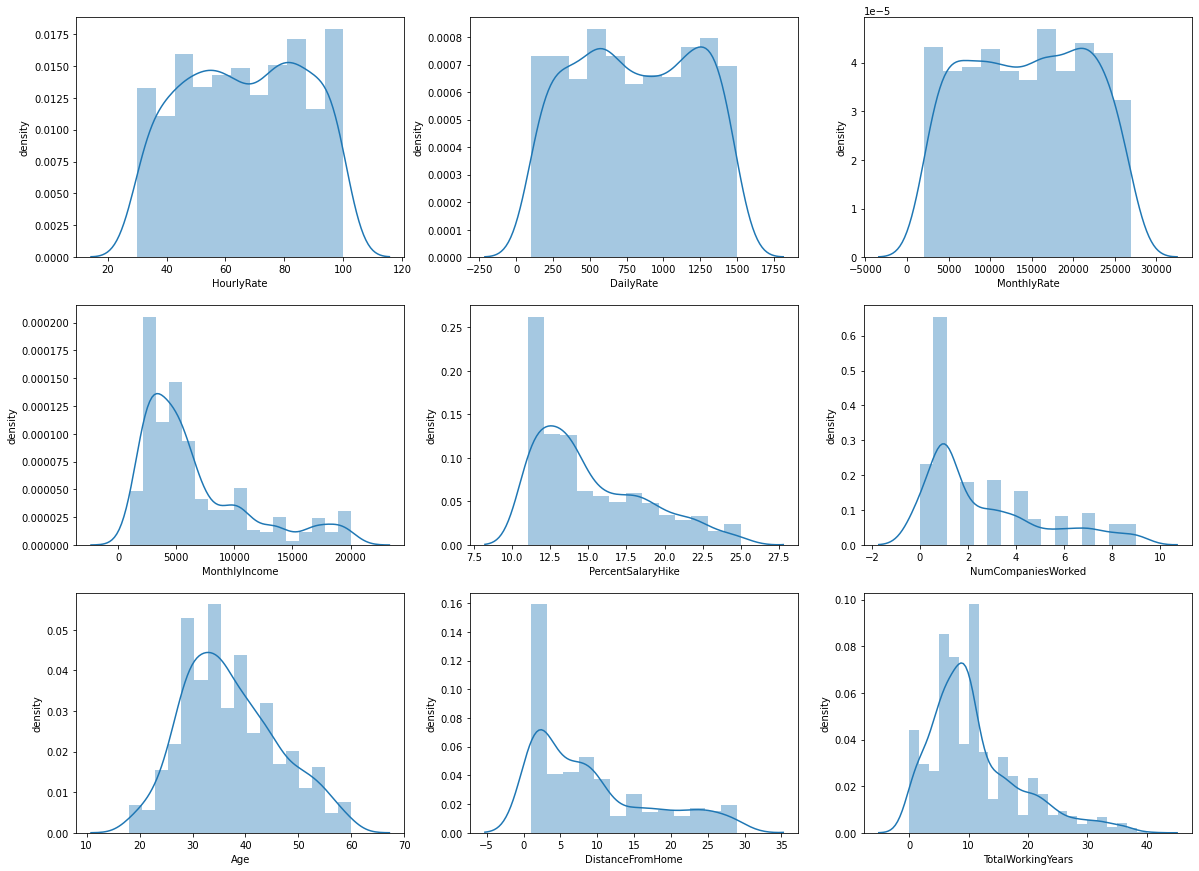

In [813]:
fig = plt.subplots(figsize=(20, 15))
fig_dims = (3, 3)

ax = plt.subplot2grid(fig_dims, (0, 0))
# histogram, where on y-axis are displayes bins' density in order to fit the data
sns.distplot(df["HourlyRate"].dropna(), kde=True)
plt.ylabel("density")
ax = plt.subplot2grid(fig_dims, (0, 1))
sns.distplot(df["DailyRate"].dropna(), kde=True)
plt.ylabel("density")
ax = plt.subplot2grid(fig_dims, (0, 2))
sns.distplot(df["MonthlyRate"].dropna(), kde=True)
plt.ylabel("density")

ax = plt.subplot2grid(fig_dims, (1, 0))
sns.distplot(df["MonthlyIncome"].dropna(), kde=True)
plt.ylabel("density")
ax = plt.subplot2grid(fig_dims, (1, 1))
sns.distplot(df["PercentSalaryHike"].dropna(), kde=True)
plt.ylabel("density")
ax = plt.subplot2grid(fig_dims, (1, 2))
sns.distplot(df["NumCompaniesWorked"].dropna(), kde=True)
plt.ylabel("density")

ax = plt.subplot2grid(fig_dims, (2, 0))
sns.distplot(df["Age"].dropna(), kde=True)
plt.ylabel("density")
ax = plt.subplot2grid(fig_dims, (2, 1))
sns.distplot(df["DistanceFromHome"].dropna(), kde=True)
plt.ylabel("density")
ax = plt.subplot2grid(fig_dims, (2, 2))
sns.distplot(df["TotalWorkingYears"].dropna(), kde=True)
plt.ylabel("density")

plt.show()

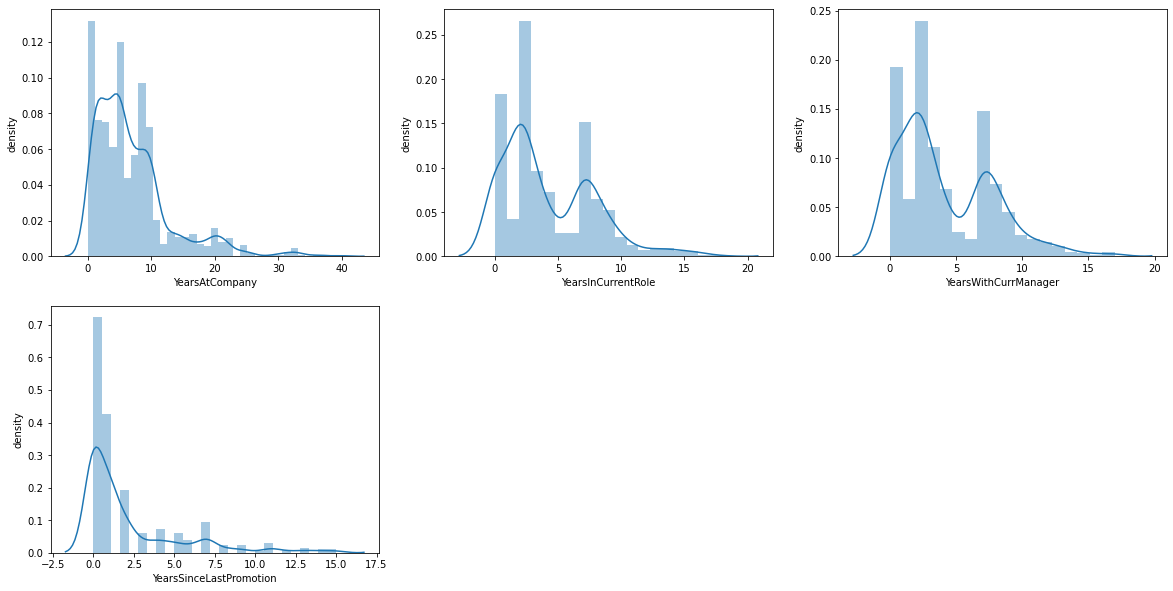

In [814]:
fig =plt.subplots(figsize=(20, 10))
fig_dims = (2, 3)

ax = plt.subplot2grid(fig_dims, (0, 0))
sns.distplot(df["YearsAtCompany"].dropna(), kde=True)
plt.ylabel("density")
ax = plt.subplot2grid(fig_dims, (0, 1))
sns.distplot(df["YearsInCurrentRole"].dropna(), kde=True)
plt.ylabel("density")
ax = plt.subplot2grid(fig_dims, (0, 2))
sns.distplot(df["YearsWithCurrManager"].dropna(), kde=True)
plt.ylabel("density")

ax = plt.subplot2grid(fig_dims, (1, 0))
sns.distplot(df["YearsSinceLastPromotion"].dropna(), kde=True)
plt.ylabel("density")

plt.show()

<h6> Graphically assess if numerical data is Gaussian distributed or not</h6>

To graphically assess if data is Gaussian like we use a  <b>Quantile-Quantile plot (QQ plot)</b>. 
It shows the distribution  of the data against the expected normal distribution.
If the data is normally distributed, the points fall on the 45° reference line. 
If the data is non-normal, the points deviate noticeably from the reference line.

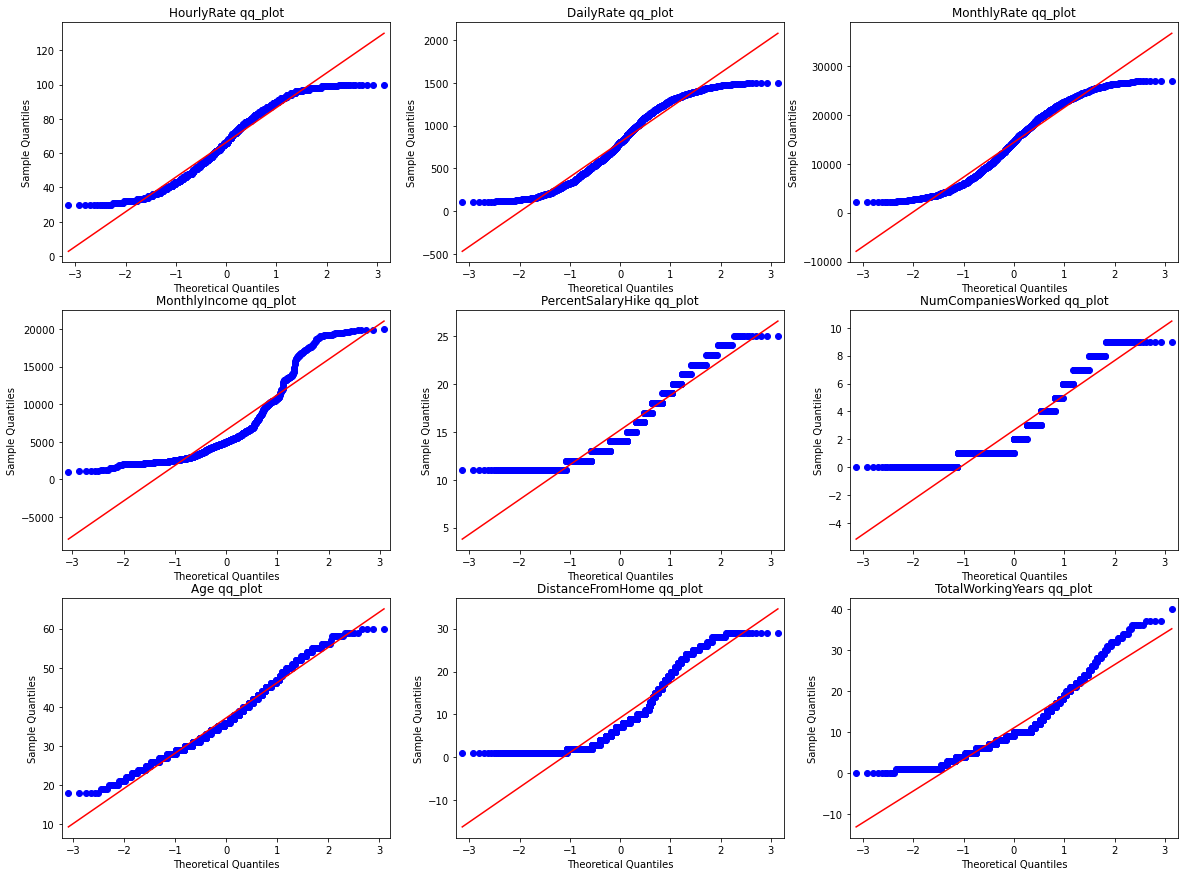

In [815]:
fig =plt.subplots(figsize=(20, 15))
fig_dims = (3, 3)

ax = plt.subplot2grid(fig_dims, (0, 0))
qqplot(df["HourlyRate"].dropna(), line='s', ax=ax)
plt.title("HourlyRate" + " qq_plot")
ax = plt.subplot2grid(fig_dims, (0, 1))
qqplot(df["DailyRate"].dropna(), line='s', ax=ax)
plt.title("DailyRate" + " qq_plot")
ax = plt.subplot2grid(fig_dims, (0, 2))
qqplot(df["MonthlyRate"].dropna(), line='s', ax=ax)
plt.title("MonthlyRate" + " qq_plot")

ax = plt.subplot2grid(fig_dims, (1, 0))
qqplot(df["MonthlyIncome"].dropna(), line='s', ax=ax)
plt.title("MonthlyIncome" + " qq_plot")
ax = plt.subplot2grid(fig_dims, (1, 1))
qqplot(df["PercentSalaryHike"].dropna(), line='s', ax=ax)
plt.title("PercentSalaryHike" + " qq_plot")
ax = plt.subplot2grid(fig_dims, (1, 2))
qqplot(df["NumCompaniesWorked"].dropna(), line='s', ax=ax)
plt.title("NumCompaniesWorked" + " qq_plot")

ax = plt.subplot2grid(fig_dims, (2, 0))
qqplot(df["Age"].dropna(), line='s', ax=ax)
plt.title("Age" + " qq_plot")
ax = plt.subplot2grid(fig_dims, (2, 1))
qqplot(df["DistanceFromHome"].dropna(), line='s', ax=ax)
plt.title("DistanceFromHome" + " qq_plot")
ax = plt.subplot2grid(fig_dims, (2, 2))
qqplot(df["TotalWorkingYears"].dropna(), line='s', ax=ax)
plt.title("TotalWorkingYears" + " qq_plot")

plt.show()

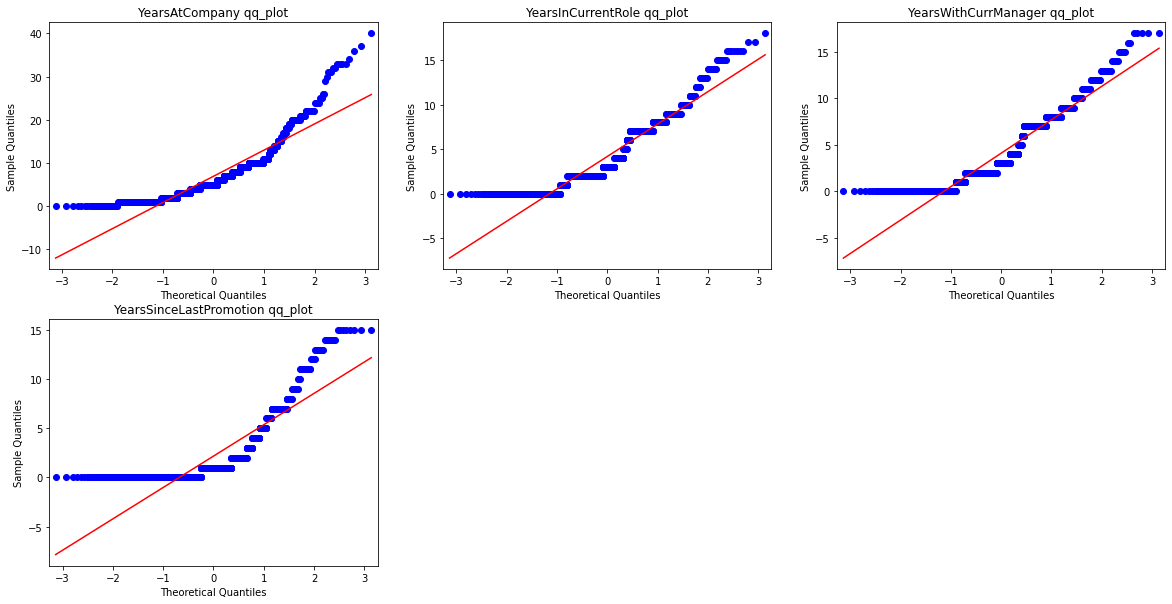

In [816]:
fig =plt.subplots(figsize=(20, 10))
fig_dims = (2, 3)

ax = plt.subplot2grid(fig_dims, (0, 0))
qqplot(df["YearsAtCompany"].dropna(), line='s', ax=ax)
plt.title("YearsAtCompany" + " qq_plot")
ax = plt.subplot2grid(fig_dims, (0, 1))
qqplot(df["YearsInCurrentRole"].dropna(), line='s', ax=ax)
plt.title("YearsInCurrentRole" + " qq_plot")
ax = plt.subplot2grid(fig_dims, (0, 2))
qqplot(df["YearsWithCurrManager"].dropna(), line='s', ax=ax)
plt.title("YearsWithCurrManager" + " qq_plot")

ax = plt.subplot2grid(fig_dims, (1, 0))
qqplot(df["YearsSinceLastPromotion"].dropna(), line='s', ax=ax)
plt.title("YearsSinceLastPromotion" + " qq_plot")

plt.show()

<h6> Statistically assess if data is Gaussian distributed or not</h6>

<b>scipy.stats.normaltest</b> function tests the null hypothesis that a sample comes from a normal distribution. It is based on D’Agostino and Pearson’s test that combines skew and kurtosis to produce an omnibus test of normality.

In [817]:
column_names = list(df.columns)
obj_columns = list(df.select_dtypes(include=['object']).columns)
for column_name in column_names:
    if column_name not in obj_columns:
        data = df[column_name].dropna()  # get each column's values, omitting NaN values 
        value, p = normaltest(data)
        if p >= 0.05:
            print('It is likely that %s is normal' % column_name)

<b>scipy.stats.kstest</b> function tests the null hypothesis that a sample comes from a normal distribution. It is based on Kolmogorov-Smirnov test.

In [818]:
column_names = list(df.columns)
obj_columns = list(df.select_dtypes(include=['object']).columns)
for column_name in column_names:
    if column_name not in obj_columns:
        data = df[column_name].dropna()  # get each column's values, omitting NaN values 
        value, p = kstest(data, 'norm')
        if p >= 0.05:
            print('It is likely that %s is normal' % column_name)

All attributes failed the NormalTest/ Kolmogorov-Smirnov tests, so theiy aren't normally distributed.

<h2> Variables statistics </h2>

In [819]:
pd.options.display.float_format = '{:.2f}'.format
df.describe()  # columns statistics

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,PercentSalaryHike,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1000.00,1176.00,1176.00,1176.00,1176.00,1176.00,1176.00,1176.00,1176.00,963.00,...,1176.00,1176.00,1176.00,1176.00,943.00,1176.00,1116.00,1176.00,1176.00,1176.00
mean,37.20,803.65,9.21,2.88,2.72,66.30,2.74,2.02,2.70,6565.95,...,15.18,2.70,0.78,11.02,2.83,2.76,6.93,4.19,2.17,4.11
std,9.02,406.68,8.10,1.02,1.09,20.27,0.72,1.07,1.10,4710.63,...,3.62,1.09,0.85,7.69,1.27,0.71,6.06,3.64,3.19,3.60
min,18.00,102.00,1.00,1.00,1.00,30.00,1.00,1.00,1.00,1009.00,...,11.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
25%,30.00,460.50,2.00,2.00,2.00,49.00,2.00,1.00,2.00,2969.00,...,12.00,2.00,0.00,6.00,2.00,2.00,3.00,2.00,0.00,2.00
50%,36.00,804.00,7.00,3.00,3.00,66.00,3.00,2.00,3.00,4969.00,...,14.00,3.00,1.00,10.00,3.00,3.00,5.00,3.00,1.00,3.00
75%,43.00,1169.00,14.00,4.00,4.00,84.00,3.00,3.00,4.00,8585.00,...,18.00,4.00,1.00,15.00,3.00,3.00,9.00,7.00,3.00,7.00
max,60.00,1499.00,29.00,5.00,4.00,100.00,4.00,5.00,4.00,19999.00,...,25.00,4.00,3.00,40.00,6.00,4.00,40.00,18.00,15.00,17.00


The data provided by the function <u>describe</u> highlight an high variance for many attributes, perhaps due to outliers (we need to assessment this later on). For now, we can estimate the <b>coefficient of variation</b>:
$$CV = \dfrac{\sigma} {\mu}$$

As a rule of thumb, a CV >= 1 indicates a relatively high variation, while a CV < 1 can be considered low. This means that distributions with a coefficient of variation higher than 1 are considered to be high variance whereas those with a CV lower than 1 are considered to be low-variance. 

In [820]:
column_names = list(df.columns)
obj_columns = list(df.select_dtypes(include=['object']).columns)
for column_name in column_names:
    if column_name not in obj_columns:
        data = df[column_name].dropna()  # get each column's values, omitting NaN values 
        cv = np.std(data) / np.mean(data)
        if cv >= 1:
            print(column_name, cv, sep="\t")

StockOptionLevel	1.086648401143309
YearsSinceLastPromotion	1.468125076120187


We consider that <b>StockOptionLevel</b>'s high CV is justified, without taking into account the presence of "real" outliers (they are indeed "natural" outliers): in fcat, the majority of our employees haven't or have few equity compensations granted by the company (we think that this is quite a common situation).

The only attribute, for which we are confident to state that contains outliers, is <b>YearsSinceLastPromotion</b>, since the majority of our employees are new promoted, while an handful of employees have at least a decade since last promotion.

<h2> Type conversion (Part 1) </h2>

Many machine learning algorithms cannot operate on label data directly. They require all input variables and output variables to be numeric. This means that categorical data must be converted to a numerical form.

This ordinal encoding transform is available in the <b>scikit-learn</b> Python machine learning library via the <b>OrdinalEncoder</b> class. By default, it will assign integers to labels in alphabetical order. If a specific
order is desired, it can be specified via the <u>categories</u> argument as a list with the rank order of all expected labels.

For categorical variables where no ordinal relationship exists, the integer encoding may not be enough or even misleading to the model. Forcing an ordinal relationship via an ordinal encoding and allowing the model to assume a natural ordering between categories may result in poor performance or unexpected results. In this case, a one
hot encoding can be applied to the ordinal representation. This is where <b>the integer encoded variable is removed and one new binary variable is added for each unique integer value in the variable</b>. This one hot encoding transform is available in the <b>scikit-learn</b> Python machine learning library via the <b>OneHotEncoder</b> class. By default, it will create new binary variables in column's values alphabetical order. If a specific
order is desired, it can be specified via the <u>categories</u> argument as a list.

<h6> Perform an integer encoding on all ordinal and nominal features (object data types)</h6>

In [821]:
def print_encoding(column_name, encoder_categories):
    """
    Function which prints the encoding undergone
    """
    print("%s's values encoded as:" % column_name)
    for i in range(0, len(encoder_categories[0])):
        print("%s" % encoder_categories[0][i], "%d" % i, sep="\t")

In [822]:
def replace_categorical_feature_with_dummy_ones(column_name, categories_list, dummy_features):
    """
    Function which replaces the nominal feature passed by argument with dummy ones, 
    to convert nominal column's M values in M new binary (dummy) features.
    """
    # retrive nominal feature's index. It is used to know where to insert the new M binary features
    index = df.columns.get_loc(column_name)
    for i in range(0, dummy_features.shape[1]):
        index += 1
        df.insert(index, column_name + "_" + str(categories_list[i].replace(" ", "_")), 
                                                              dummy_features[:, i].todense().astype(int), True)
    # remove categorical feature
    del df[column_name]

In ordert to encode our not already encoded categorical features, we have to select them. We do this by looking at all object type columns in the dataset:

In [823]:
# select columns which are of object datatype 
df_mod = df.select_dtypes(include=['object'])
df_mod.dtypes

Attrition         object
BusinessTravel    object
Department        object
EducationField    object
Gender            object
JobRole           object
MaritalStatus     object
OverTime          object
dtype: object

Our dataset has <b>8 categorical features not already encoded</b>, sub-divided as follows:

<b> nominal features (6): </b>
- Attrition;  
- Department;
- EducationField;
- Gender;
- OverTime;
- JobRole.

<b> ordinal features (2): </b>  
- BusinessTravel;
- MaritalStatus;


Before encoding these categorical variables, however, we have to check if they have missing values, because otherwise the NaN values will be replaced, too (it is possible to explicitly avoid this, but for simplicity we will replace missing values with each column's mode).

In [824]:
# check for any null values present in the categorical data
df_mod.isnull().sum()

Attrition           0
BusinessTravel    107
Department          0
EducationField      0
Gender             59
JobRole             0
MaritalStatus       0
OverTime            0
dtype: int64

Our dataset present 1 nominal and 1 ordinal feature with missing values, so we are going to replace all NaN values with the most common value in each column ("Travel_Rarely" for "BusinessTravel" and "Male" for "Gender", as we saw from the data distribution above):

In [825]:
# replacing null values with most frequent value ('Travel_Rarely', 'Male')
column_names = ["BusinessTravel", "Gender"]
for column_name in column_names:
    # summarize total missing values
    print('%s missing before inputation: %d ' % (column_name, df[column_name].isnull().sum()))
    # define the imputer model
    imputer = SimpleImputer(missing_values=np.NaN, strategy='most_frequent')
    # fit the model on the dataset to impute its missing values and transform it
    df[column_name] = imputer.fit_transform(df[column_name].values.reshape(-1,1))[:,0]
    # summarize total missing values
    print('%s missing after inputation:: %d ' % (column_name, df[column_name].isnull().sum()))

BusinessTravel missing before inputation: 107 
BusinessTravel missing after inputation:: 0 
Gender missing before inputation: 59 
Gender missing after inputation:: 0 


Since we are not sure if our DataFrame may be useful in the future without the encoded values, we will make a copy of it, before proceeding with our encoding process:

In [826]:
df_not_encoded = df.copy() # keep track of NOT encoded dataset

From now on we will proceed with our object values encoding, using the <b>OrdinalEncoder</b> and the <b>OneHotEncoder</b> as appropriate:

In [827]:
# create binary encoder 
encoder = OrdinalEncoder(categories=[['No', 'Yes']])  # excplict force encoding order
# fit and transform model on data
df["Attrition"] = encoder.fit_transform(df["Attrition"].values.reshape(-1,1))[:,0].astype(int)
df["OverTime"] = encoder.fit_transform(df["OverTime"].values.reshape(-1,1))[:,0].astype(int)
print_encoding("Attrition", encoder.categories_)
print()
print_encoding("OverTime", encoder.categories_)

Attrition's values encoded as:
No	0
Yes	1

OverTime's values encoded as:
No	0
Yes	1


In [828]:
# create binary encoder 
encoder = OrdinalEncoder(categories=[['Male', 'Female']])   # excplict force encoding order
# fit and transform model on data
df["Gender"] = encoder.fit_transform(df["Gender"].values.reshape(-1,1))[:,0].astype(int)
print_encoding("Gender", encoder.categories_)

Gender's values encoded as:
Male	0
Female	1


In [829]:
# create ordinal encoder 
column_name = "BusinessTravel"
categories_list = ["Non-Travel", "Travel_Rarely", "Travel_Frequently"] 
encoder = OneHotEncoder(categories=[categories_list])   # excplict force encoding order
# fit and transform model on data
dummy_features = encoder.fit_transform(df[column_name].values.reshape(-1,1))
# add dummy features to dataset, replacing categorical feature
replace_categorical_feature_with_dummy_ones(column_name, categories_list, dummy_features)
print_encoding(column_name, encoder.categories_)
df.shape  # checking insertion

BusinessTravel's values encoded as:
Non-Travel	0
Travel_Rarely	1
Travel_Frequently	2


(1176, 32)

In [830]:
# create ordinary encoder 
column_name = "MaritalStatus"
categories_list = ["Single", "Married", "Divorced"]
encoder = OneHotEncoder(categories=[categories_list])   # excplict force encoding order
# fit and transform model on data
dummy_features = encoder.fit_transform(df[column_name].values.reshape(-1,1))
# add dummy features to dataset, replacing categorical feature
replace_categorical_feature_with_dummy_ones(column_name, categories_list, dummy_features)
print_encoding(column_name, encoder.categories_)
df.shape  # checking insertion

MaritalStatus's values encoded as:
Single	0
Married	1
Divorced	2


(1176, 34)

In [831]:
# create categorical encoder 
column_name = "Department"
categories_list = sorted(df[column_name].unique())
encoder = OneHotEncoder()
# fit and transform model on data
dummy_features = encoder.fit_transform(df[column_name].values.reshape(-1,1))
# add dummy features to dataset, replacing categorical feature
replace_categorical_feature_with_dummy_ones(column_name, categories_list, dummy_features)
print_encoding(column_name, encoder.categories_)
df.shape  # checking insertion

Department's values encoded as:
Human Resources	0
Research & Development	1
Sales	2


(1176, 36)

In [832]:
# create categorical encoder 
column_name = "EducationField"
categories_list = sorted(df[column_name].unique())
encoder = OneHotEncoder()
# fit and transform model on data
dummy_features = encoder.fit_transform(df[column_name].values.reshape(-1,1))
# add dummy features to dataset, replacing categorical feature
replace_categorical_feature_with_dummy_ones(column_name, categories_list, dummy_features)
print_encoding(column_name, encoder.categories_)
df.shape  # checking insertion

EducationField's values encoded as:
Human Resources	0
Life Sciences	1
Marketing	2
Medical	3
Other	4
Technical Degree	5


(1176, 41)

In [833]:
# create categorical encoder 
column_name = "JobRole"
categories_list = sorted(df[column_name].unique())
encoder = OneHotEncoder()
# fit and transform model on data
dummy_features = encoder.fit_transform(df[column_name].values.reshape(-1,1))
# add dummy features to dataset, replacing categorical feature
replace_categorical_feature_with_dummy_ones(column_name, categories_list, dummy_features)
print_encoding(column_name, encoder.categories_)
df.shape  # checking insertion

JobRole's values encoded as:
Healthcare Representative	0
Human Resources	1
Laboratory Technician	2
Manager	3
Manufacturing Director	4
Research Director	5
Research Scientist	6
Sales Executive	7
Sales Representative	8


(1176, 49)

In [834]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1176 entries, 0 to 1175
Data columns (total 49 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Age                                1000 non-null   float64
 1   Attrition                          1176 non-null   int64  
 2   BusinessTravel_Non-Travel          1176 non-null   int64  
 3   BusinessTravel_Travel_Rarely       1176 non-null   int64  
 4   BusinessTravel_Travel_Frequently   1176 non-null   int64  
 5   DailyRate                          1176 non-null   int64  
 6   Department_Human_Resources         1176 non-null   int64  
 7   Department_Research_&_Development  1176 non-null   int64  
 8   Department_Sales                   1176 non-null   int64  
 9   DistanceFromHome                   1176 non-null   int64  
 10  Education                          1176 non-null   int64  
 11  EducationField_Human_Resources     1176 non-null   int64

A we can see from our DataFram recap, all data object features are encoded. All our variables are int64 types, with the exection of <b>Age</b>, <b>MonthlyIncome</b>, <b>TrainingTimesLastYear</b> and <b> YearsAtCompany</b> which still have missing values (we will address this problem in section <b>Missing data imputation</b>, as well as performing the convertion from int64 to float64 in section <b>Type conversion (Part 2)</b>).

<h2> Univariate outliers detection </h2>

<h6> Standard Deviation Method (for Guassian distributed values) </h6>
The Gaussian distribution has the property that the standard deviation from the mean can be used to reliably
summarize the percentage of values in the sample.
So, if the mean is x and the standard deviation is y, then all data in the sample between x - y and x + y will account for about 68% of the data sample. We can cover more of the data sample if we expand the
range as follows:<br>
- 1 Standard Deviation from the Mean: 68%; <br>
- 2 Standard Deviations from the Mean: 95%; <br>
- 3 Standard Deviations from the Mean: 99.7%.

The common value for detecting outliers is to consider 3 Standard Deviation from the Mean as a cut-off (2 Standard Deviation from the Mean if the dataset is small). 

Since in our dataset all attributes failed the Normaltest/ Kolmogorov-Smirnov test in section <b>Variables distribution</b>, we will skip this outlier elimination method.

<h6> Interquartile Range Method (non-Gaussian distributed values) </h6>
The IQR can be used to identify outliers by defining limits on the sample values that are a <b>factor k of the IQR below the 25th percentile or above the 75th percentile</b>. The common value for the factor k is the value <b>1.5</b>. A factor k of 3 or more can be used to identify values that are extreme outliers or far outs when described in the context of box and whisker plots. Our dataset is small, so will try with k = 1.5, but if too many outliers will be detected we will have to be more restrictive and shift to k = 3: @TODO

In [835]:
def get_interquartile_cut_off(data, k): 
    # calculate interquartile range
    q25, q75 = percentile(data, 25), percentile(data, 75)
    iqr = q75 - q25
    # calculate the outlier cutoff
    cut_off = iqr * k
    lower, upper = q25 - cut_off, q75 + cut_off
    return q25, q75, cut_off, lower, upper 

<h6> Assess graphically outliers through box and whisker plots </h6>

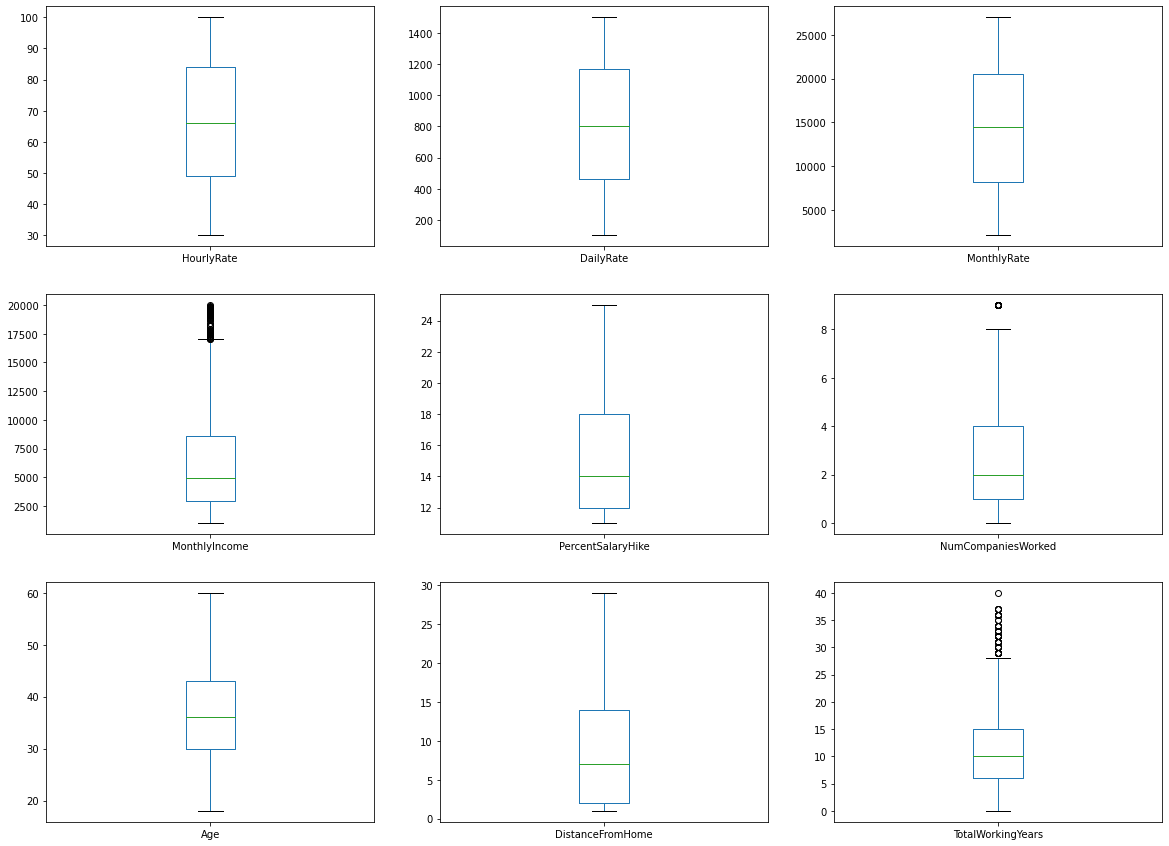

In [836]:
fig =plt.subplots(figsize=(20, 15))
fig_dims = (3, 3)
ax = plt.subplot2grid(fig_dims, (0, 0))
df["HourlyRate"].plot.box(ax=ax)
ax = plt.subplot2grid(fig_dims, (0, 1))
df["DailyRate"].plot.box(ax=ax)
ax = plt.subplot2grid(fig_dims, (0, 2))
df["MonthlyRate"].plot.box(ax=ax)

ax = plt.subplot2grid(fig_dims, (1, 0))
df["MonthlyIncome"].plot.box(ax=ax)
ax = plt.subplot2grid(fig_dims, (1, 1))
df["PercentSalaryHike"].plot.box(ax=ax)
ax = plt.subplot2grid(fig_dims, (1, 2))
df["NumCompaniesWorked"].plot.box(ax=ax)

ax = plt.subplot2grid(fig_dims, (2, 0))
df["Age"].plot.box(ax=ax)
ax = plt.subplot2grid(fig_dims, (2, 1))
df["DistanceFromHome"].plot.box(ax=ax)
ax = plt.subplot2grid(fig_dims, (2, 2))
df["TotalWorkingYears"].plot.box(ax=ax)

plt.show()

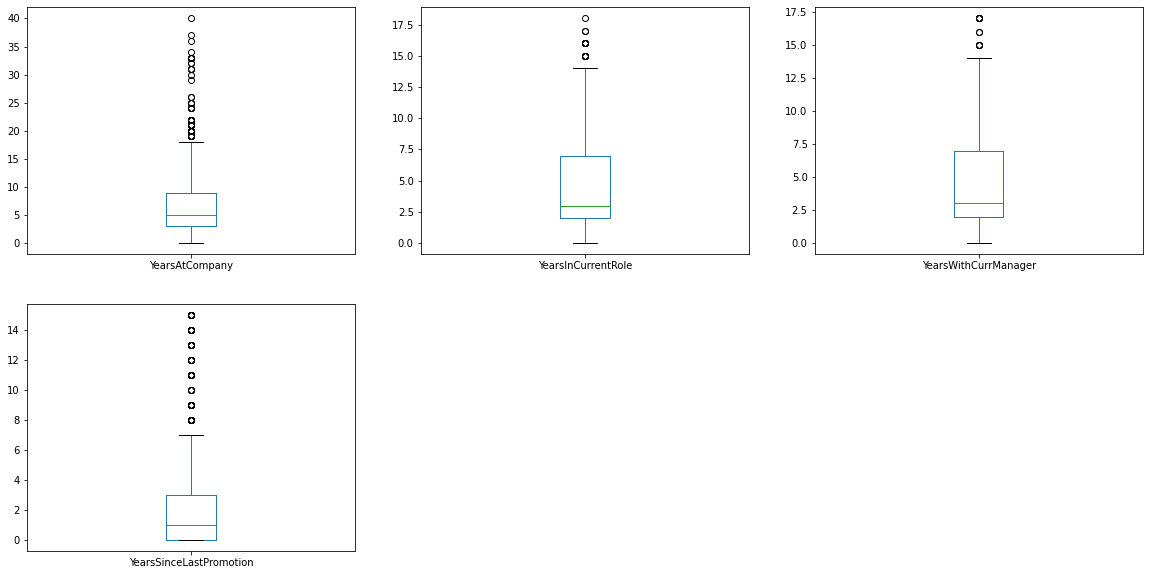

In [837]:
fig =plt.subplots(figsize=(20, 10))
fig_dims = (2, 3)
ax = plt.subplot2grid(fig_dims, (0, 0))
df["YearsAtCompany"].plot.box(ax=ax)
ax = plt.subplot2grid(fig_dims, (0, 1))
df["YearsInCurrentRole"].plot.box(ax=ax)
ax = plt.subplot2grid(fig_dims, (0, 2))
df["YearsWithCurrManager"].plot.box(ax=ax)

ax = plt.subplot2grid(fig_dims, (1, 0))
df["YearsSinceLastPromotion"].plot.box(ax=ax)

plt.show()

From the above box and whisker plots we can see that <b>7 features are biased with ouliers</b>:
- MonthlyIncome
- NumCompaniesWorked
- TotalWorkingYears
- YearsAtCompany
- YearsInCurrentRole
- YearsWithCurrentManager
- YearsSinceLastPromotion

This is confirmed by the IQR, too, as shown bellow. Since some attributes are categorical (their cut-off is nearby 0, more preciselly <= 1.500) we will omitt them in the outlier detection process, since we will remove enitire category of employees belonging to one or more optionions of the categorical attribute (which already has a low value cardinality):

In [838]:
column_names = list(df.columns)
for column_name in column_names:
    data = df[column_name].dropna()  # get each column's values, omitting NaN values 
    # get the outlier cutoff
    q25, q75, cut_off, lower, upper = get_interquartile_cut_off(data, 1.5)
    # identify outlier
    outliers = {}
    outliers["lower"] = []
    outliers["upper"] = []
    for x in data:
        if x < lower:
            tmp_list =  outliers["lower"]
            tmp_list.append(x)
            outliers["lower"] = tmp_list
        elif x > upper:
            tmp_list =  outliers["upper"]
            tmp_list.append(x)
            outliers["upper"] = tmp_list
                
    tot_outliers = len(outliers["lower"]) + len(outliers["upper"])
    if tot_outliers > 0 and cut_off > 1.500: # cut_off > 1.500: avoid ordinal values elimination 
        print( '%s\'s percentiles: 25th=%.3f, 75th=%.3f, cut_off=%.3f, outliers: %d' 
                        % (column_name, q25, q75, cut_off, tot_outliers))
        df = df.drop(df[df[column_name] < lower].index)  # remove employees under lower 
        df = df.drop(df[df[column_name] > upper].index)  # remove employees above upper 
        
df.shape  # checking removal output

MonthlyIncome's percentiles: 25th=2969.000, 75th=8585.000, cut_off=8424.000, outliers: 63
NumCompaniesWorked's percentiles: 25th=1.000, 75th=4.000, cut_off=4.500, outliers: 39
TotalWorkingYears's percentiles: 25th=6.000, 75th=15.000, cut_off=13.500, outliers: 44
YearsAtCompany's percentiles: 25th=3.000, 75th=9.000, cut_off=9.000, outliers: 42
YearsInCurrentRole's percentiles: 25th=2.000, 75th=7.000, cut_off=7.500, outliers: 11
YearsSinceLastPromotion's percentiles: 25th=0.000, 75th=2.000, cut_off=3.000, outliers: 134
YearsWithCurrManager's percentiles: 25th=1.000, 75th=5.000, cut_off=6.000, outliers: 19


(824, 49)

After the outlier detection process, we provided to remove them from our DataFrame, resulting in lighter dataset composed by 824 rows. 

<h2> Dimensionality Reduction (Part 2)</h2>
In this section we will remove redundant features using correlation.

<h6> Data Normalization </h6>

Many machine learning algorithms perform better when numerical input variables are scaled to a standard range, since the scale and distribution of dataset's data may be different for each variable.This difference in scale for input variables does not affect all machine learning algorithms. For example, algorithms that fit a model that use a weighted sum of input variables or distance measures between examples are affected, such as k-nearest neighbors and support vector machines. There are also algorithms that are unaffected by the scale of numerical input variables, most notably decision trees and ensembles of trees, like
random forest.


The two most popular techniques for scaling numerical data prior to modeling are <b>normalization</b> and <b>standardization</b>. Since our dataset doesn't contain Gaussian distributed feature we will normalize it.

Normalization is a rescaling of the data from the original range so that all values are within the
new range of 0 and 1. A value is normalized as follows:
$$y = \dfrac{x - min}{max - min}$$
where the minimum and maximum values pertain to the value x being normalized.

The <b>scikit-learn</b> machine learning library provides the <b>MinMaxScaler</b> class that supports data normalisation. The default scale for the MinMaxScaler is to rescale variables into the range \[0, 1\], although
a preferred scale can be specified via the <u>feature_range</u> argument as a tuple containing the
min and the max for all variables. If needed, the transform can be inverted (this is useful for converting predictions back into their original scale), this can be done by calling the <b>inverse_transform()</b>
function.

In [839]:
df_norm = df.copy()  # make a copy of the DataFrame to perform normalisation on it

In [840]:
# for column_name in columns_to_normalize:
column_names = list(df.columns)
for column_name in column_names:
    # data = df[column_name].fillna(-1)  # convert NaN values to integers (-1) 
    data = df_norm[column_name]
    # define the scaler model
    scaler = MinMaxScaler()
    # fit the model on the feature to normale its values and transform it
    df_norm[column_name] = scaler.fit_transform(df_norm[column_name].values.reshape(-1,1))[:, 0]
# normalized input variable's summarry
df_norm.describe()  

,Age,Attrition,BusinessTravel_Non-Travel,BusinessTravel_Travel_Rarely,BusinessTravel_Travel_Frequently,DailyRate,Department_Human_Resources,Department_Research_&_Development,Department_Sales,DistanceFromHome,...,PercentSalaryHike,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,698.00,824.00,824.00,824.00,824.00,824.00,824.00,824.00,824.00,824.00,...,824.00,824.00,824.00,824.00,664.00,824.00,778.00,824.00,824.00,824.00
mean,0.43,0.17,0.10,0.73,0.17,0.51,0.04,0.64,0.31,0.29,...,0.31,0.57,0.26,0.32,0.47,0.59,0.31,0.23,0.20,0.29
std,0.21,0.38,0.31,0.44,0.37,0.29,0.20,0.48,0.46,0.28,...,0.26,0.36,0.29,0.21,0.21,0.24,0.22,0.21,0.26,0.26
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.29,0.00,0.00,0.00,0.00,0.26,0.00,0.00,0.00,0.04,...,0.07,0.33,0.00,0.18,0.33,0.33,0.11,0.07,0.00,0.09
50%,0.40,0.00,0.00,1.00,0.00,0.51,0.00,1.00,0.00,0.21,...,0.21,0.67,0.33,0.29,0.50,0.67,0.28,0.14,0.20,0.18
75%,0.55,0.00,0.00,1.00,0.00,0.77,0.00,1.00,1.00,0.44,...,0.50,1.00,0.33,0.39,0.50,0.67,0.44,0.36,0.20,0.39
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [841]:
# check if normalisation was performed well
for column_name in columns_to_normalize:
    data = df_norm[column_name]
    d_min = min(data)
    d_max = max(data)
    d_std = np.std(data)

    if d_min != 0:
        print("min %f error %s" % (d_min, column_name))

    if d_max < 0.99 or d_max > 1.01:  # handle overlow errors
        print("max %f error %s" % (d_max, column_name))

    if d_std >= 1.0:
        print("std %f error %s" % (d_std, column_name))

We can see that the distributions have been adjusted and that the minimum and maximum values for categorical or numerical variables are now a crisp 0.0 and 1.0 respectively.

<h6>Correlations</h6>

In [842]:
def draw_sns_heatmap(correlation_matrix, h_neg, h_pos, title, pngfile):
    """
    Function which draws a seaborn' heatmap based on the correlation matrix passed by argument
    """
    # generate a mask for the upper triangle
    mask = np.zeros_like(correlation_matrix, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # set up the matplotlib figure
    fig, ax = plt.subplots(figsize=(16, 14))

    # generate a custom diverging colormap
    cmap = sns.diverging_palette(h_neg, h_pos, as_cmap=True)
    
    # draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.title(title)

    # save figure
    fig.savefig(plot_directory + pngfile)

<h6> Person correlation coefficient </h6> <br>
$$\rho_{xy} = \dfrac{Cov(x, y)}{\sigma_{x}, \sigma_{y}}$$ <br>
where: <br>
- $Cov(x, y)$ is the covariance between variable x and y; <br>
- $\sigma_{x}$ and $\sigma_{y}$ are variables' standard deviations. <br>

Values always range between -1 (strong negative relationship) and +1 (strong positive relationship). Values at or close to zero imply weak or no linear relationship.

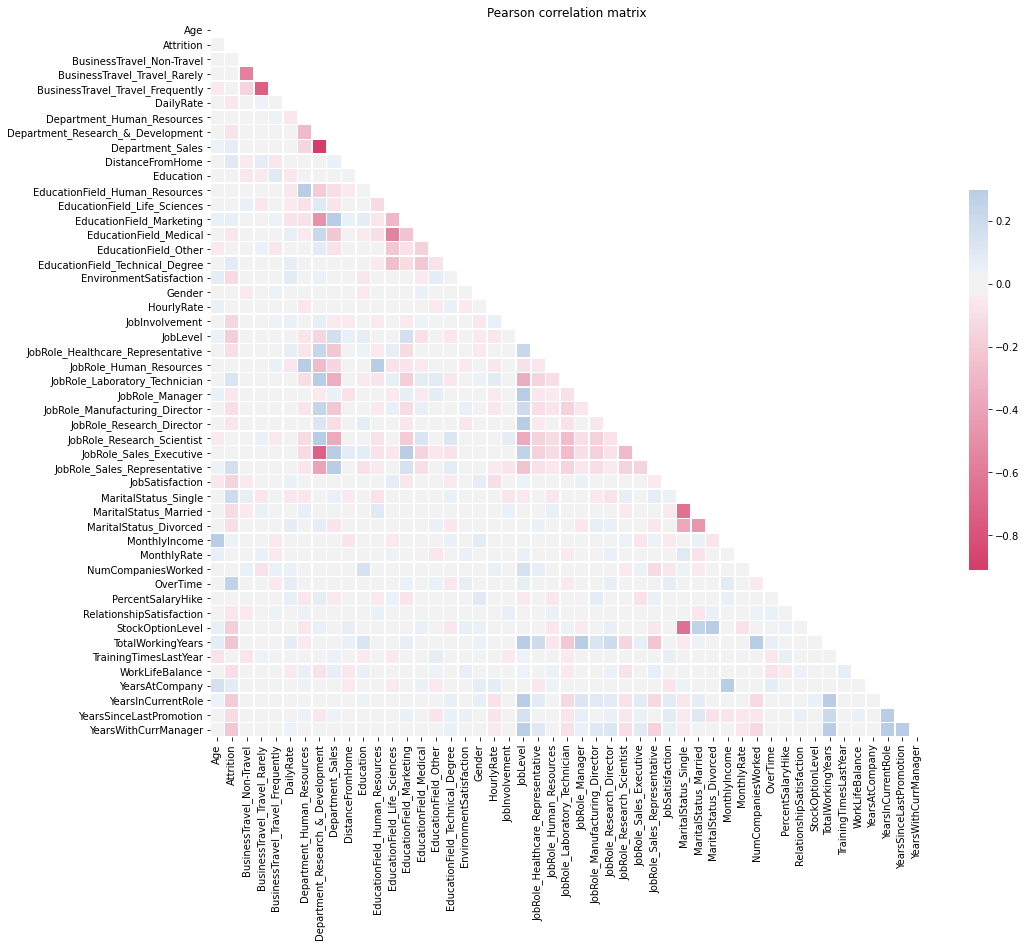

In [843]:
# compute the correlation matrix, excluding NA/null values
correlation_matrix = df_norm.corr("pearson")  # pearson correlation
# draw heatmap
draw_sns_heatmap(correlation_matrix, 0, 250, "Pearson correlation matrix", "pearson_correlation_matrix.png")

<h6> Sperarman correlation coefficient </h6> <br>
$$r = \rho_{rg_{x}rg_{y}} = \dfrac{Cov(rg_{x}, rg_{y})}{\sigma_{rg_{x}}, \sigma_{rg_{y}}}$$ <br>
where: <br>
- $rg_{x}$ and $rg_{y}$ are variable's x and y rankings; <br>
- $Cov(rg_{x}, rg_{y})$ is rankings' covariance; <br>
- $\sigma_{rg_{x}}$ and $\sigma_{rg_{y}}$ are rankings' standard deviations. <br>

Values always range between -1 (strong negative relationship) and +1 (strong positive relationship). Values at or close to zero imply weak or no relationship.

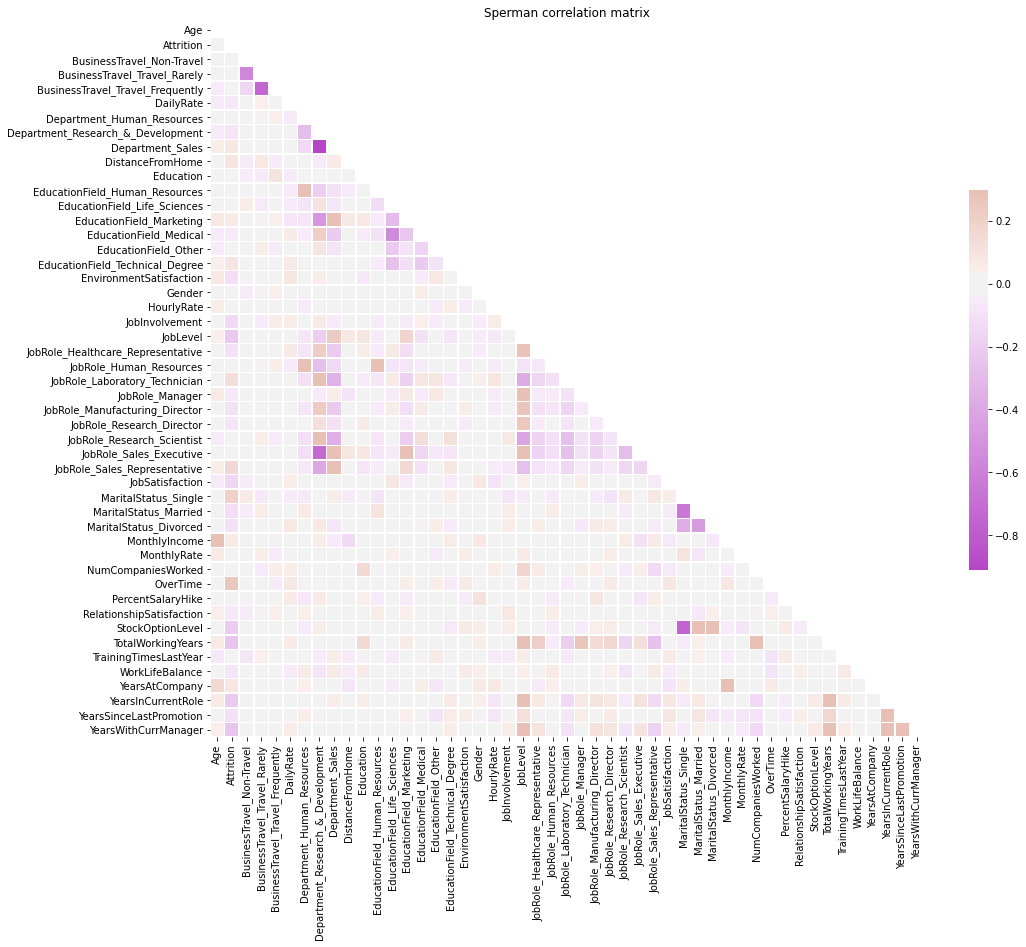

In [844]:
# compute the correlation matrix, excluding NA/null values
correlation_matrix = df_norm.corr("spearman")  # spearman correlation
# draw heatmap
draw_sns_heatmap(correlation_matrix, 300, 20, "Sperman correlation matrix", "spearman_correlation_matrix.png")

<h6> Kendall correlation coefficient </h6> <br>
$$\tau_{xy} = \dfrac{n_{c} - n_{d}}{n(n - 1) / 2}$$ <br>
where: <br>
- $n_{c}$ and $n_{d}$ are the number of concordan or discordant pairs $(x_{i}, y_{i})$, i=1,...,n; <br>
- $n(n - 1) / 2$ is the total number of pairings. <br>

Values always range between -1 (strong negative relationship) and +1 (strong positive relationship). Values at or close to zero imply weak or no relationship.

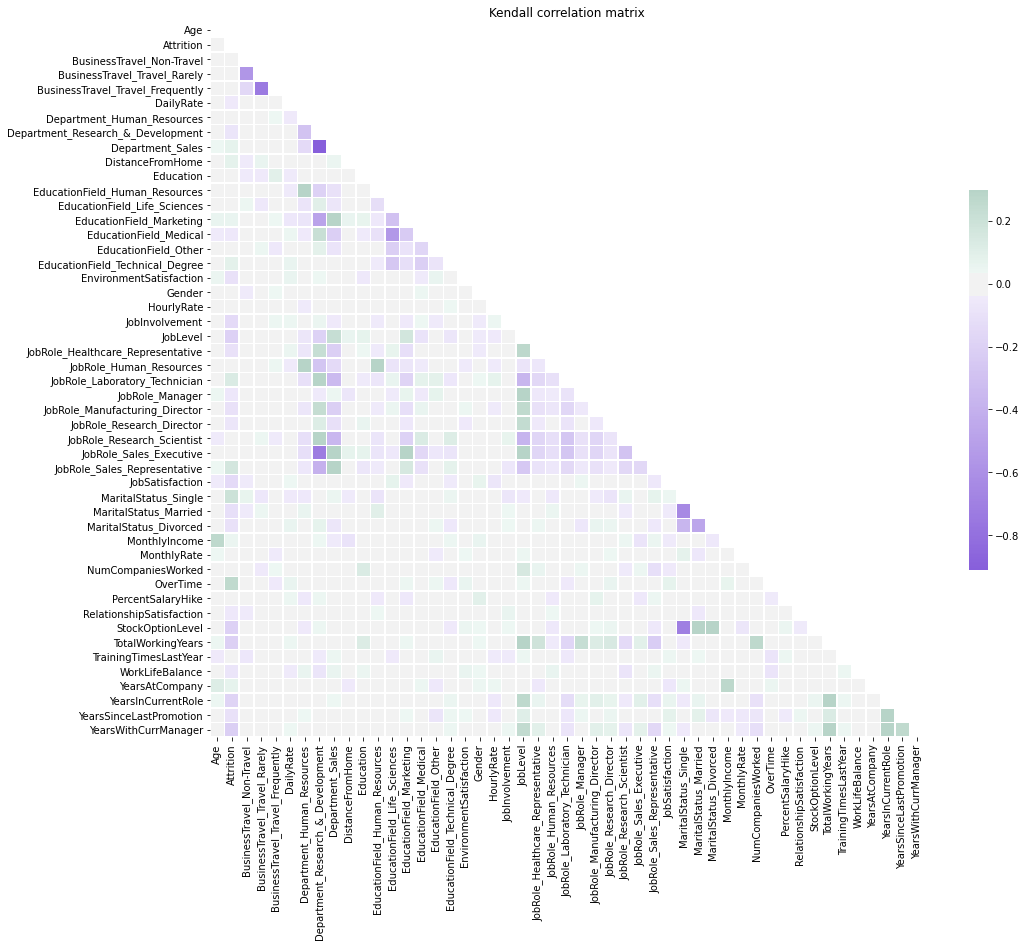

In [845]:
# compute the correlation matrix, excluding NA/null values
correlation_matrix = df_norm.corr("kendall")  # kendall correlation
# draw heatmap
draw_sns_heatmap(correlation_matrix, 275, 150, "Kendall correlation matrix", "kendall_correlation_matrix.png")

<h6> Pearson correlation investigation </h6>
Since "Pearson", "Spearman" and "Kendall"'s correlations are equivalent, we will stick with <b>Pearson correlation</b> in our dimensional reduction process. In particular we will remove columns highly correlated given a <b>threshold equal to |0.5|</b>: 

In [846]:
# investigating positive correlation
threshold = 0.5
corr_matrix = df.corr("pearson")
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
            print(corr_matrix.columns[i], corr_matrix.columns[j])

EducationField_Human_Resources Department_Human_Resources
EducationField_Marketing Department_Sales
JobRole_Human_Resources Department_Human_Resources
JobRole_Sales_Executive Department_Sales
TotalWorkingYears JobLevel
YearsWithCurrManager YearsInCurrentRole


In [847]:
# investigating negative correlation
threshold = -0.5
corr_matrix = df.corr("pearson")
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if (corr_matrix.iloc[i, j] <= threshold) and (corr_matrix.columns[j] not in col_corr):
            print(corr_matrix.columns[i], corr_matrix.columns[j])

BusinessTravel_Travel_Rarely BusinessTravel_Non-Travel
BusinessTravel_Travel_Frequently BusinessTravel_Travel_Rarely
Department_Sales Department_Research_&_Development
EducationField_Medical EducationField_Life_Sciences
JobRole_Sales_Executive Department_Research_&_Development
MaritalStatus_Married MaritalStatus_Single
StockOptionLevel MaritalStatus_Single


From the Pearson correlation we found out that we can <b>remove</b> <b>"MaritalStatus"</b>, <b>"Department", "TotalWorkingYears", "YearsWithCurrManager"</b> features which are implictly encoded in "StockOptionLevel"\* "JobRole", "JobLevel", "YearsInCurrentRole" features. 

\*  StockOptionLevel is granted to married/divorced employees

<h6> Highly correlated features dropping </h6>

In [848]:
to_drop = ["Department_Research_&_Development", "Department_Sales","Department_Human_Resources",
           "MaritalStatus_Single", "MaritalStatus_Married", "MaritalStatus_Divorced","TotalWorkingYears",
           "YearsWithCurrManager"]

# drop features 
for column_name in to_drop:
    del df[column_name]
    del df_norm[column_name]

# check dropping output
print(df.shape)
print(df_norm.shape)

(824, 41)
(824, 41)


<h2>Missing data imputation @TODO</h2>

In [849]:
# checking again columns' missing data
column_names = list(df.columns)
for column_name in column_names:
    # count number of rows with missing values
    data = df[column_name]
    n_miss = data.isnull().sum()
    perc = n_miss / df.shape[0] * 100
    if n_miss > 0:
        print( '%s, Missing: %d (%.1f%% of rows) ' % (column_name, n_miss, perc))

Age, Missing: 126 (15.3% of rows) 
MonthlyIncome, Missing: 171 (20.8% of rows) 
TrainingTimesLastYear, Missing: 160 (19.4% of rows) 
YearsAtCompany, Missing: 46 (5.6% of rows) 


<h6> Statistical imputation strategy </h6>

A popular approach for data imputation is to calculate a statistical value for each column (such as a mean\*/ median\*\*/ mode\*\*\*/ costant value) and replace all missing values for that column with the statistic. It is a popular approach because the statistic is easy to calculate using the training dataset and because it often results in good performance. 

\*columns' average values;<br>
\*\*middle element in ascending ordered column;<br>
\*\*\*most frequent element in column.

The <b>scikit-learn</b> machine learning library provides the <b>SimpleImputer</b> class that supports statistical imputation.
The SimpleImputer is a data transform, which needs the following parameters:
- the type of the missing values to replace via the <u>missing_values</u> argument;
- the type of statistic to calculate for each column via the <u>strategy</u> argument. 

Then, the imputer is fit on the dataset, creating a copy of the dataset with all missing values for each column replaced with an estimated value.

We will use the <b>mode imputation strategy</b> with the following feature:
- TrainingTimesLastYear;

since it is a numerical attributes with low cardinality ranginf from 0 to 6. We will handle the replacement taking the most common element in the column (TrainingTimeLastYear=2), since this won't compromise any other feature in the dataset, since "TrainingTimeLastYear" is not correlated to any other column.

In [ ]:
def de_normalise_column(norm_column):
    de_norm_column = numpy.zeros(shape=(norm_column.shape[0] ,1))
    max_d = df[column_name].max()
    min_d = df[column_name].min()
        
    for row in norm_column:
        denorm_value = norm_value * (max_d - min_d) + min_d
        return denorm_value

In [851]:
column_names = ["TrainingTimesLastYear"]
for column_name in column_names:
    # summarize total missing values
    print('%s missing: %d ' % (column_name, df_norm[column_name].isnull().sum()))
    # define the imputer model
    imputer = SimpleImputer(missing_values=np.NaN, strategy='most_frequent')
    # fit the model on the dataset to impute its missing values and transform it
    df_norm[column_name] = imputer.fit_transform(df_norm[column_name].values.reshape(-1,1))[:,0]
    # keep track of inputation also in original dataframe
    # df[column_name]  = de_normalise_column(df_norm[column_name])
    # summarize total missing values
    print('%s missing: %d ' % (column_name, df_norm[column_name].isnull().sum()))

TrainingTimesLastYear missing: 160 
TrainingTimesLastYear missing: 0 


@TODO decide what imputation to use for numerical faetures

<b>Nearest Neighbor imputation strategy (KNN imputation)</b>

A popular approach to missing data imputation is to use a model to predict the missing values. This requires a model to be created for each input variable that has missing values. Although any one among a range of different models can be used to predict the missing values, the k-nearest neighbor (KNN) algorithm has proven to be generally effective.

A new sample is imputed by finding the samples in the training set “closest” to it and averages these nearby points to fill in the value. Configuration of KNN imputation involves selecting the <b>distance measure</b> (e.g. Euclidean) and the <b>number of contributing neighbors</b> for each prediction, the k hyperparameter of
the KNN algorithm.

The <b>scikit-learn</b> machine learning library provides the <b>KNNImputer class</b> that supports nearest
neighbor imputation. <br>
The KNNImputer is a data transform, which needs the following parameters:
- the default distance measure is the Euclidean distance measure that is NaN aware, e.g. will not include NaN values when calculating the distance between members of the training dataset. This is set via the <u>metric</u> argument;
- the number of neighbors is set to 5 by default and can be configured by the <u>n_neighbors</u> argument;
- the distance measure can be weighed proportional to the distance between instances (rows), although this is set to a uniform weighting by default, controlled via the <u>weights</u> argument.

Then, the imputer is fit on the dataset, creating a copy of the dataset with all missing values for each column replaced with an estimated value.

We will use the <b>mode imputation strategy</b> with the following features:
- Age;
- MonthlyIncome;
- YearsAtCompany;

since their being numerical discrete attributes best suits the replacement with values correlated to "similar" neighbours.

In [ ]:
knn_df_norm = df_norm.copy()

In [ ]:
column_names = ["Age", "MonthlyIncome", "YearsAtCompany"]
for column_name in column_names:
    # summarize total missing values
    print('%s missing: %d ' % (column_name, knn_df_norm[column_name].isnull().sum()))
    # define the imputer model
    imputer =  KNNImputer()
    # fit the model on the dataset to impute its missing values and transform it
    knn_df_norm[column_name] = imputer.fit_transform(knn_df_norm[column_name].values.reshape(-1,1))[:,0]
    # keep track of inputation also in original dataframe
    df[column_name]  = knn_df_norm[column_name] 
    # summarize total missing values
    print('%s missing: %d ' % (column_name, knn_df_norm[column_name].isnull().sum()))

<h6>Iterative imputation strategy</h6>
One approach to imputing missing values is to use an iterative imputation model. Iterative imputation refers to a process where each feature is modeled as a function of the other features, e.g. a regression problem where missing values are predicted. Each feature is imputed sequentially, one after the other, allowing prior imputed values to be used as part of a model in predicting subsequent features. It is iterative because this process is repeated multiple times, allowing ever improved estimates of missing values to be calculated as missing values across all features are estimated. This approach may be generally referred to as multivariate imputation by chained equations (MICE).

The <b>scikit-learn</b> machine learning library provides the <b>IterativeImputer</b> class that supports iterative imputation.
The IterativeImputer is a data transform, which needs the following parameters:
- the estimator to use at each step of the round-robin imputation via the <u>estimator</u> arguemnt;
- the number of other features to use to estimate the missing values of each feature column. To ensure coverage of features throughout the imputation process, the neighbor features are not necessarily nearest, but are drawn with probability proportional to correlation for each imputed target feature (if None, all features will be used) via the <u>n_nearest_features</u> argument;
- The order in which the features will be imputed via the <u>imputation_order</u> argument (default "ascending", from those with the fewest missing values to those with the most; this makes sense as we want to have more complete data when it comes time to estimating missing values for columns where the majority of values are missing).

N.B. By default, the IterativeImputer will repeat the number of iterations 10 times. However, it is possible to specify the number of iterations of the procedure  via the <u>max_iter</u> argument.

We will use the mode imputation strategy with the following features:

- Age;
- MonthlyIncome;
- YearsAtCompany;

since their being numerical discrete attributes best suits the replacement with values predicted by correlated features.

In [ ]:
iter_df_norm = df_norm.copy()

In [ ]:
column_names = ["Age", "MonthlyIncome", "YearsAtCompany"]
for column_name in column_names:
    # summarize total missing values
    print('%s missing: %d ' % (column_name, iter_df_norm[column_name].isnull().sum()))
     # define the imputer model
    imputer = IterativeImputer(estimator=BayesianRidge(), n_nearest_features=None,imputation_order='ascending')
    # fit the model on the dataset to impute its missing values and transform it
    iter_df_norm[column_name] = imputer.fit_transform(iter_df_norm[column_name].values.reshape(-1,1))[:,0]
    # keep track of inputation also in original dataframe
    df[column_name]  = iter_df_norm[column_name] 
    # summarize total missing values
    print('%s missing: %d ' % (column_name, iter_df_norm[column_name].isnull().sum()))

<h2>Type conversion (Part 2)</h2>

<h6>Convert all float64 elements to int64 </h6>

In [ ]:
# converting float type to int
df["Age"] = df["Age"].astype(int) 
df["MonthlyIncome"] = df["MonthlyIncome"].astype(int) 
df["TrainingTimesLastYear"] = df["TrainingTimesLastYear"].astype(int) 
df["YearsAtCompany "] = df["YearsAtCompany"].astype(int) 

<h2> Data discretization @TODO</h2>

Some machine learning algorithms may prefer or require categorical or ordinal input variables, such as some decision tree and rule-based algorithms. As such, it is often desirable to transform each input variable to have a standard probability distribution. One approach is to use a transform of the numerical variable to have a discrete probability distribution where each numerical value is assigned a label and the labels have an ordered (ordinal) relationship. This is called a <b>binning</b> or a <b>discretization</b> transform and can improve the performance of some machine learning models for datasets by making the probability distribution of numerical input variables discrete.

Different methods for grouping the values into k discrete bins can be used; common techniques
include:
- uniform: each bin has the same width in the span of possible values for the variable;
- quantile: each bin has the same number of values, split based on percentiles;
- clustered: clusters are identified and examples are assigned to each group.

The discretization transform is available in the <b>scikit-learn</b> Python machine learning library via the <b>KBinsDiscretizer</b> class, having the following parameters:
- the <u>strategy</u> argument controls the manner in which the input variable is divided, as either 'uniform', 'quantile', or 'kmeans';
- the <u>n_bins</u> argument controls the number of bins that will be created and must be set based on the choice of strategy, e.g. ‘uniform’ is flexible, ‘quantile’ must have a 'n_bins' less than the number of observations or sensible percentiles, and ‘kmeans’ must use a value for the number of clusters that can be reasonably found;
- the <u>encode</u> argument controls whether the transform will map each value to an integer value by setting ‘ordinal’ or a one hot encoding ‘onehot’. An ordinal encoding is almost always preferred, although a one hot encoding may allow a model to learn non-ordinal relationships between the groups, such as in the case of K-Means clustering strategy.

For simplicity we will stick with an <b>uniform data discretisation</b>, setting the number of bins as we better evaluate each feature and converting the numerical values into fixed number of discrete categories with an ranked ordinal relationship.

<h6> Convert "MonthlyIncome" into an ordinal variable </h6>

In [ ]:
# perform a uniform discretization transform of the dataset
trans = KBinsDiscretizer(n_bins=11, encode='ordinal', strategy='uniform')
df["MonthlyIncome"] = trans.fit_transform(df["MonthlyIncome"].values.reshape(-1,1))[:,0]
print(df["MonthlyIncome"].unique())

<h6> Convert "Age" into an ordinal variable </h6>

In [ ]:
df["Age"] = trans.fit_transform(df["Age"].values.reshape(-1,1))[:,0]
df["Age"] = trans.fit_transform(df["Age"].values.reshape(-1,1))[:,0]
print(df["Age"].unique())

<h2> New feature extraction @TODO </h2>

Often, the input features for a predictive modeling task interact in unexpected and often
nonlinear ways. A possible approach is to engineer new features that expose these interactions and see if they
improve model performance. In particular, we will use <b>polynomial feature transforms</b> for feature engineering with numerical input variables.

Polynomial features are those features created by raising existing features to an exponent. For example, if a dataset had one input feature X, then a polynomial feature would be the addition of a new feature (column) where values were calculated by squaring the values in X, e.g. X^2 . This process can be repeated for each input variable in the dataset, creating a transformed version of each. As such, polynomial features are a type of feature engineering, e.g. the creation of new input features based on the existing features. Typically a small degree is used such as 2 or 3.

It is also common to add new variables that represent the interaction between features, e.g a new column that represents one variable multiplied by another or the creation, ex-novo, of a new feature starting from the input ones. 

These two last types of feature extraction can be done thanks to the dataminer's skills and intuition, while the polynomial features transform is available in the zb>scikit-learn</b> Python machine learning library via the <b>PolynomialFeatures</b> class, having the following parameters:
- the <u>degree</u> argument controls the number of features created and defaults to 2;
- the <u>interaction_only</u> argument means that only the raw values (degree 1) and the interaction
(pairs of values multiplied with each other) are included, defaulting to False;
- the <u>include_bias</u> argument, defaults to True, to include the bias feature.
